In [2]:
import geopandas as gp
import pandas as pd
import numpy as np
from scipy.stats import linregress
import subprocess
import os,sys
import emcee
import statsmodels.api as sm
import pylab
from scipy.stats import norm
import seaborn as sn
import corner
from scipy import optimize,linalg
import matplotlib.pyplot as plt
import multiprocessing 

def shell(cmd):
    #print(cmd)
    process = subprocess.Popen([sys.executable]+cmd.split(" "),
                     stdout=subprocess.PIPE, 
                     stderr=subprocess.PIPE,text=True)
    stdout, stderr = process.communicate()
    if not process.returncode==0:
        try:
            print(cmd)
            print(stdout)
            print(stderr)
        except:
            print("failed to decode stdout/stderr")
        return False
    #print(stdout)
    return True



In [3]:
import numpy as np
import torch
torch.from_numpy(np.array([]))

tensor([], dtype=torch.float64)

In [4]:
input_nets = {"finaltest":"../data/highways_finaltest_prep.shp",
              "bulwark":"../data/bulwark_input.shp"}
def test_drape(input_net,spatial_mismatch_prior_scale,slope_prior_scale,slope_continuity_prior_scale,pitch_angle_prior_scale,refresh=True):
    input_net_filename = input_nets[input_net]
    outbase = input_net_filename[0:-4]
    bayes_output_filename = outbase + f"-bdrape-{spatial_mismatch_prior_scale}-{slope_prior_scale}-{slope_continuity_prior_scale}-{pitch_angle_prior_scale}.shp"
    if refresh or not os.path.exists(bayes_output_filename):
        res=shell(f"../BayesianDrape.py --TERRAIN-INPUT=../data/all_os50_terrain.tif --POLYLINE-INPUT={input_net_filename} "
              f"--OUTPUT={bayes_output_filename} --SPATIAL-MISMATCH-PRIOR-SCALE={spatial_mismatch_prior_scale} "
              f"--SLOPE-CONTINUITY-PRIOR-SCALE={slope_continuity_prior_scale} --SLOPE-PRIOR-SCALE={slope_prior_scale} "
              f"--PITCH-ANGLE-PRIOR-SCALE={pitch_angle_prior_scale} "
              f"--MAXITER=10000 --DECOUPLE-FIELD=bridge --IGNORE-PROJ-MISMATCH --SPATIAL-MISMATCH-MAX=200")
        if not res:
            return False
    return bayes_output_filename


In [5]:
def markov_speed_factor(slope):
    '''https://link.springer.com/article/10.1007/s11116-019-10021-x#Tab5'''
    return (slope>0)*np.exp(-9.044*slope)+(slope<=0)*1
        

In [6]:
from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def elev_change(geom):
    ec = 0
    for (_,_,z1),(_,_,z2) in pairwise(list(geom.coords)):
        ec += abs(z2-z1)
    return ec

def plot_elev_profile(geom,title):
    plt.figure()
    zs = [geom.coords[0][2]]
    xs = [0]
    for (x1,y1,z1),(x2,y2,z2) in  pairwise(list(geom.coords)):
        xs += [xs[-1] + ((y2-y1)**2+(x2-x1)**2)**0.5]
        zs += [z2]
    plt.scatter(xs,zs)
    plt.plot(xs,zs)
    plt.xlabel("Horizontal distance (metres)")
    plt.ylabel("Elevation (metres)")
    plt.title(title)
    plt.show()

def cycletime(slope,length):
    # bodge based on linear model for now:
    # 0% slope = factor of 1
    # 5% slope = factor of 2.2 
    # slopefac = slope*100/5*1.2+1
    slopefac = 1./markov_speed_factor(slope)
    return slopefac*length

# this is equiv to ct = ec*100/5*1.2 + len when previously we were comparing on ec
# i.e. comparing on 24*ec+len which will lessen importance of ec on long links
# is this the desired result? i wanted to study outliers more; i guess this studies outliers of grade?

def get_resids_r_ll(df,x,y):
    lr = linregress(df[x],df[y])
    resids = df[y]-(lr.intercept+lr.slope*df[x])
    scale = resids.std()
    loglik = norm(loc=0,scale=scale).logpdf(resids).sum()
    return resids,lr.rvalue,loglik,lr.slope,lr.intercept
        
   
def evaluate_drape_raw(smps,sps=90,scps=90,paps=np.inf,compare="ELEVCHANGE",maxct=8000,maxec=300,label=""):
    #slope = np.arctan(sloperat*smp)*180/np.pi did i have this before to remove interactions?
    draped_net_filename = test_drape("finaltest",smps,sps,scps,paps)
    if not draped_net_filename:
        return -np.inf

    draped_net = gp.read_file(draped_net_filename)
    draped_net["draped_elev_change"]=[elev_change(geom) for geom in draped_net.geometry]
    draped_net["length"]=draped_net.geometry.length

    def height(s):
        assert s[-1]=="m"
        return float(s[0:-1])
    draped_net["os_elev_change"] = draped_net.apply(lambda row: height(row["elevationG"])+height(row["elevatio_1"]),
                                                    axis=1)

    draped_net["os_slope"] = draped_net.os_elev_change/draped_net.length
    draped_net["draped_slope"] = draped_net.draped_elev_change/draped_net.length
    draped_net["os_cycletime"] = cycletime(draped_net.os_slope,draped_net.length)
    draped_net["draped_cycletime"] = cycletime(draped_net.draped_slope,draped_net.length)

    
    resids,r,ll,slope,intercept = get_resids_r_ll(draped_net,"draped_elev_change","os_elev_change")
    elev_error_per_len = abs(resids).sum()/draped_net.length.sum()
    #print ("Max elevation outliers",min(resids),max(resids))
    draped_net["Eresid"] = resids
    #resids,r,ll,_ = get_resids_r_ll(draped_net,"os_cycletime","draped_cycletime")
    #print ("Mean abs ct error per km",abs(resids).mean()/draped_net.length.sum()*1000)
    #print ("Max ct outliers",min(resids),max(resids))
    #draped_net["CTresid"] = resids
    #draped_net.to_file(draped_net_filename)

    #print("max ct",max(draped_net.os_cycletime.max(),draped_net.draped_cycletime.max()))
    maxec_actual = max(draped_net.os_elev_change.max(),draped_net.draped_elev_change.max())
    assert maxec_actual<maxec

    #draped_net.plot.scatter("os_elev_change","draped_elev_change",xlim=(0,maxec),ylim=(0,maxec))
    #draped_net.plot.scatter("os_cycletime","draped_cycletime",xlim=(0,maxct),ylim=(0,maxct))

    # ID=1172 in highways_finaltest_prep
    bigsweir = draped_net[draped_net.ID==1172].geometry.iloc[0]
    plot_elev_profile(bigsweir,"Problem elevation profile 1 (Riverside track)")
    
    # fid=1099 in bulwark_input
    bulwark_filename = test_drape("bulwark",smps,sps,scps,paps)
    assert(bulwark_filename)
    bulwark_net = gp.read_file(bulwark_filename)
    bulwark = bulwark_net[bulwark_net.fid==1099].geometry.iloc[0]
    plot_elev_profile(bulwark,"Problem elevation profile 2 (National Cycle Network)")
    
    outputs = [
        ("label",label),
        ("smp",smps),
        ("slope",sps),
        ("cont",scps),
        ("ang",paps),
        ("R",r),
        ("loglik",ll),
        ("coeff",slope),
        ("int",intercept),
        ("ec/len err",elev_error_per_len),
        ("min outlier",min(resids)),
        ("max outlier",max(resids)),
        ("riverside ec",elev_change(bigsweir)),
        ("ncn ec",elev_change(bulwark))
    ]
    for name,value in outputs:
        print(f"{name}: {value}")
    
    keys = [x[0] for x in outputs]
    values = [x[1] for x in outputs]
    outfile = "sensitivity2.csv"
    try:
        df = pd.read_csv(outfile)
    except FileNotFoundError:
        df = pd.DataFrame(columns=keys)
    df = df.append(dict(zip(keys,values)),ignore_index=True)
    df.to_csv(outfile,index=False)


In [7]:
smps = np.linspace(1,7,15)**2
print (smps)

[ 1.          2.04081633  3.44897959  5.2244898   7.36734694  9.87755102
 12.75510204 16.         19.6122449  23.59183673 27.93877551 32.65306122
 37.73469388 43.18367347 49.        ]


In [7]:
def sensitivity(slope=90,cont=np.inf,pitch=np.inf,label="sens"):
    for smp in smps:
        evaluate_drape_raw(smp,slope,cont,pitch,label=label)

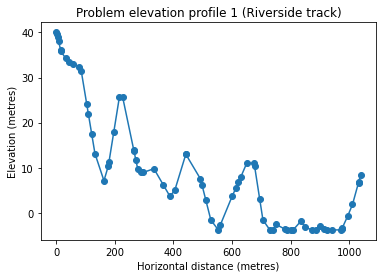

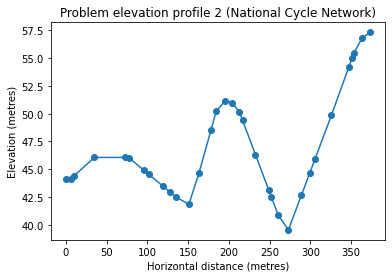

label: slp+pitch2
smp: 1.0
slope: 2.66
cont: inf
ang: 1.28
R: 0.9743637929501455
loglik: -3994.5423607458997
coeff: 0.9373987806679214
int: 0.49081740933169726
ec/len err: 0.007587548218457519
min outlier: -82.84279254722378
max outlier: 15.891698131713682
riverside ec: 151.11175527341877
ncn ec: 44.93511350610735


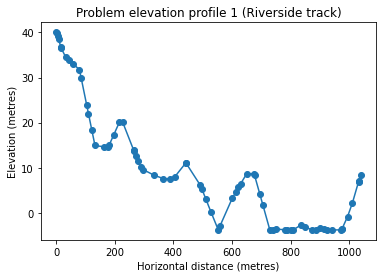

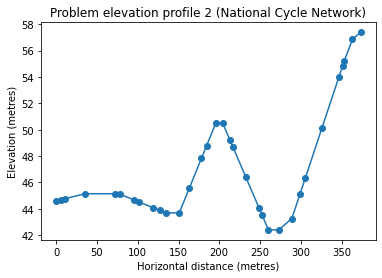

label: slp+pitch2
smp: 2.0408163265306123
slope: 2.66
cont: inf
ang: 1.28
R: 0.9856936349371419
loglik: -3590.2370134519942
coeff: 0.9882043810832107
int: 0.2561432141023019
ec/len err: 0.006326358949628213
min outlier: -42.41527688547706
max outlier: 17.175676753454766
riverside ec: 102.67019213187591
ncn ec: 31.89848721577055


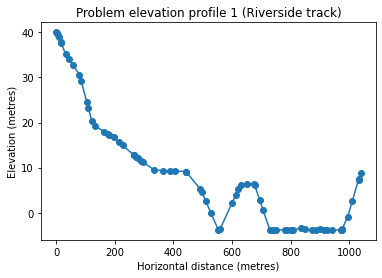

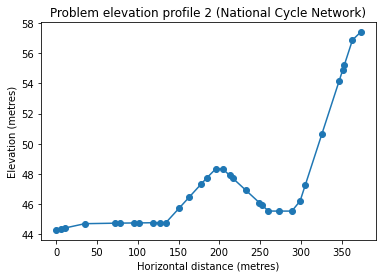

label: slp+pitch2
smp: 3.4489795918367347
slope: 2.66
cont: inf
ang: 1.28
R: 0.988112231797178
loglik: -3461.452911680971
coeff: 1.0098345479241841
int: 0.2477541132089165
ec/len err: 0.0061278254060438565
min outlier: -35.896449336510386
max outlier: 24.417279340825104
riverside ec: 77.9893197962254
ncn ec: 18.70445641492519


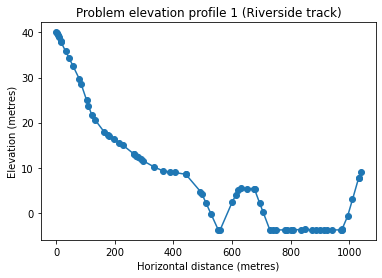

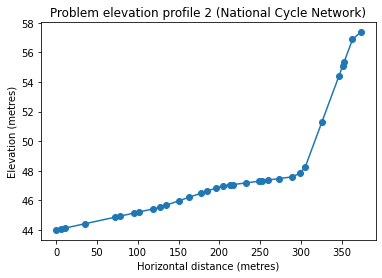

label: slp+pitch2
smp: 5.224489795918367
slope: 2.66
cont: inf
ang: 1.28
R: 0.9880504240880097
loglik: -3465.061209183322
coeff: 1.0146342151901715
int: 0.2821166020410164
ec/len err: 0.006181494581886843
min outlier: -35.4759896975241
max outlier: 27.266406422264396
riverside ec: 75.41464940126221
ncn ec: 13.360033984232984


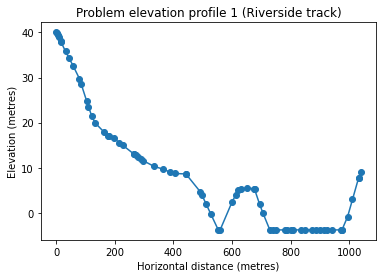

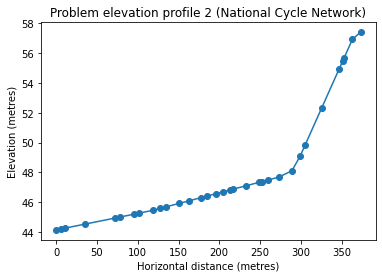

label: slp+pitch2
smp: 7.367346938775511
slope: 2.66
cont: inf
ang: 1.28
R: 0.9880671986838662
loglik: -3464.0837780169313
coeff: 1.0145022048941037
int: 0.2827848378729403
ec/len err: 0.006184195046798685
min outlier: -35.26411098172153
max outlier: 27.188408213076244
riverside ec: 75.23722345233699
ncn ec: 13.251549285450807


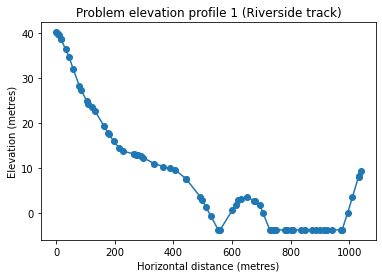

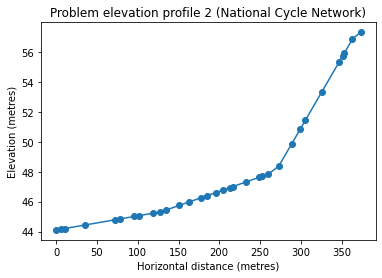

label: slp+pitch2
smp: 9.877551020408163
slope: 2.66
cont: inf
ang: 1.28
R: 0.9871925950037201
loglik: -3513.288510007305
coeff: 1.023318782819852
int: 0.34380470360017945
ec/len err: 0.006390631796352757
min outlier: -35.613054732158616
max outlier: 33.15713942287198
riverside ec: 71.75274139752543
ncn ec: 13.217385665827912


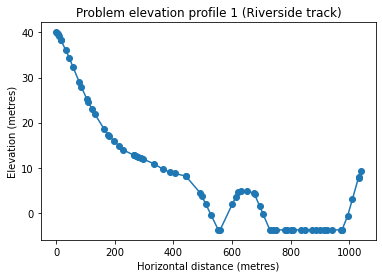

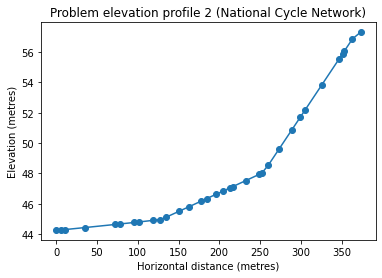

label: slp+pitch2
smp: 12.755102040816325
slope: 2.66
cont: inf
ang: 1.28
R: 0.9879330467944216
loglik: -3471.862229870768
coeff: 1.0177965540335678
int: 0.3071020191787035
ec/len err: 0.006237878025363009
min outlier: -34.9959784015646
max outlier: 29.227027564490612
riverside ec: 74.09701823743816
ncn ec: 13.009436411229238


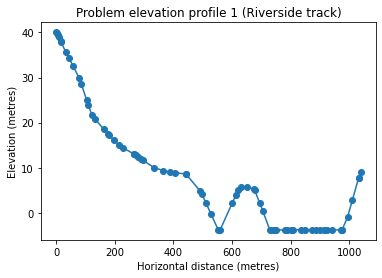

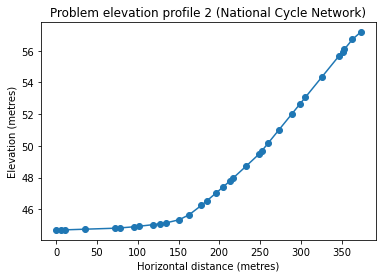

label: slp+pitch2
smp: 16.0
slope: 2.66
cont: inf
ang: 1.28
R: 0.9881090207846999
loglik: -3461.6408330105887
coeff: 1.014151714158862
int: 0.2795419011360316
ec/len err: 0.006171115661906468
min outlier: -35.23892872041198
max outlier: 26.8844344275805
riverside ec: 75.9431611887408
ncn ec: 12.466922415337827


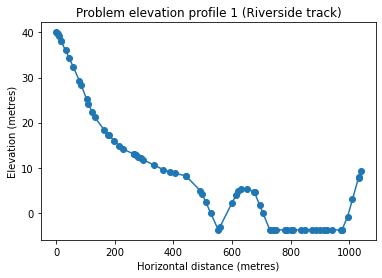

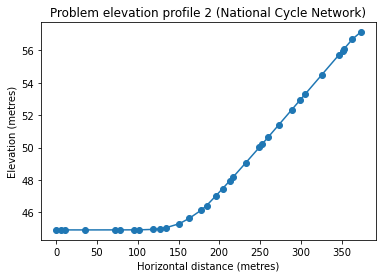

label: slp+pitch2
smp: 19.612244897959187
slope: 2.66
cont: inf
ang: 1.28
R: 0.98805030695195
loglik: -3465.068029675681
coeff: 1.015949313249054
int: 0.29306954802064844
ec/len err: 0.006205331958141299
min outlier: -34.784511222351284
max outlier: 27.849079763567644
riverside ec: 75.07059144316878
ncn ec: 12.21403960858251


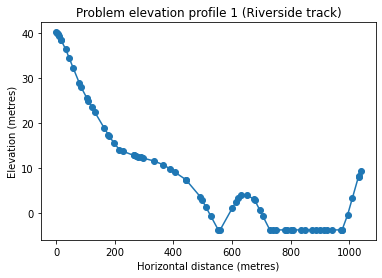

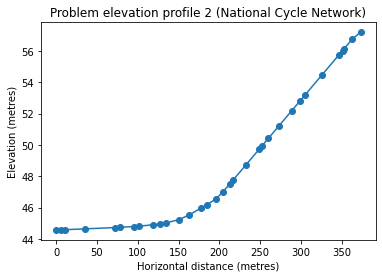

label: slp+pitch2
smp: 23.591836734693874
slope: 2.66
cont: inf
ang: 1.28
R: 0.987339552592844
loglik: -3505.2617408751003
coeff: 1.0223052985281673
int: 0.34036080506088773
ec/len err: 0.00636856849452662
min outlier: -35.394370048375876
max outlier: 32.215300898089154
riverside ec: 72.55189061467794
ncn ec: 12.622152753796804


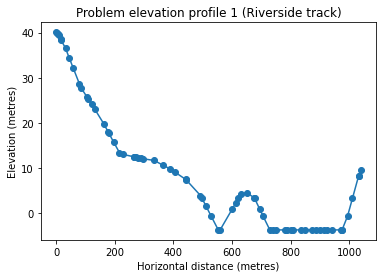

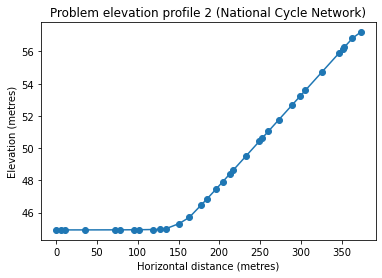

label: slp+pitch2
smp: 27.93877551020408
slope: 2.66
cont: inf
ang: 1.28
R: 0.9876247137817322
loglik: -3489.4152523464013
coeff: 1.0206547944933662
int: 0.32633812358890424
ec/len err: 0.0063024499719046044
min outlier: -35.25828085775241
max outlier: 31.0494271940153
riverside ec: 73.58090672991965
ncn ec: 12.265357785554471


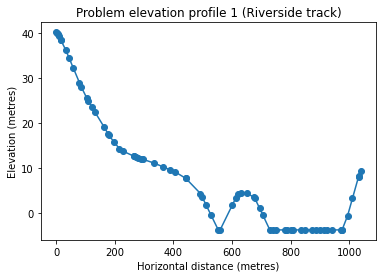

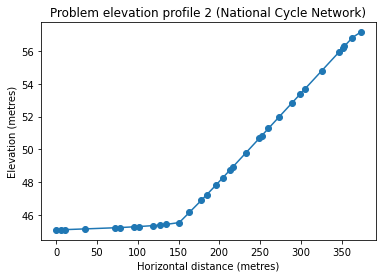

label: slp+pitch2
smp: 32.6530612244898
slope: 2.66
cont: inf
ang: 1.28
R: 0.987705507596351
loglik: -3484.8586728366954
coeff: 1.0198000099979874
int: 0.3231076563674318
ec/len err: 0.006285815169301909
min outlier: -35.22813676715489
max outlier: 30.51747934901713
riverside ec: 73.24971927579901
ncn ec: 12.096327814840862


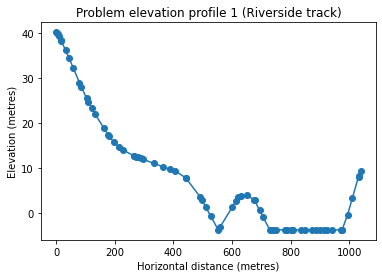

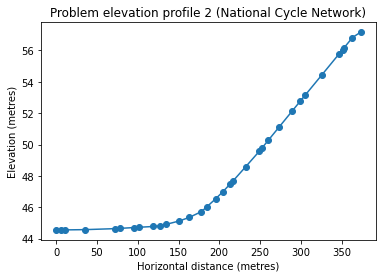

label: slp+pitch2
smp: 37.73469387755102
slope: 2.66
cont: inf
ang: 1.28
R: 0.9873314801988254
loglik: -3505.705080431093
coeff: 1.0223025827123764
int: 0.3410920691735786
ec/len err: 0.006370987961543714
min outlier: -35.392275293105115
max outlier: 32.0795846646859
riverside ec: 72.51614568651651
ncn ec: 12.609830326554338


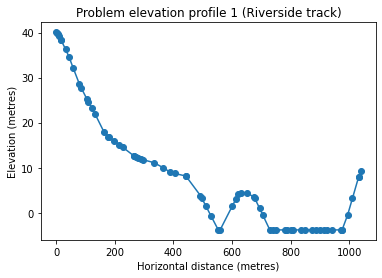

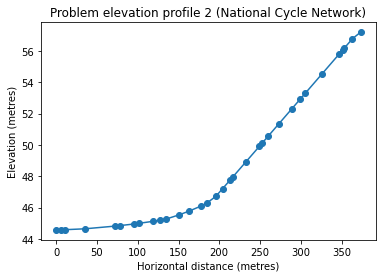

label: slp+pitch2
smp: 43.18367346938775
slope: 2.66
cont: inf
ang: 1.28
R: 0.9876901037937977
loglik: -3485.729731058699
coeff: 1.019980245135549
int: 0.3256494812170896
ec/len err: 0.006294321047175017
min outlier: -35.20859365013831
max outlier: 30.559652099952515
riverside ec: 73.30293131232361
ncn ec: 12.611927640243174


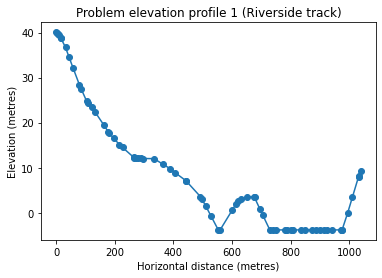

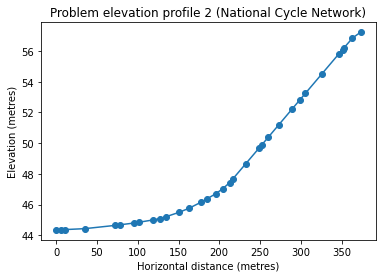

label: slp+pitch2
smp: 49.0
slope: 2.66
cont: inf
ang: 1.28
R: 0.9873160475618694
loglik: -3506.551857080912
coeff: 1.0230410840815116
int: 0.3432784044320254
ec/len err: 0.006379610945760196
min outlier: -35.462785660230296
max outlier: 32.89193381714637
riverside ec: 71.60422706345612
ncn ec: 12.86787402159149


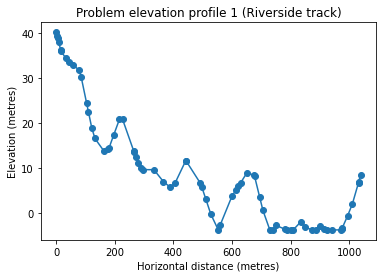

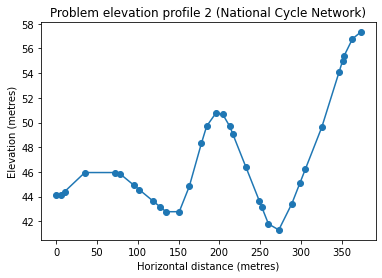

label: slp+cont+weakpitch2
smp: 1.0
slope: 2.66
cont: 2.66
ang: 2.56
R: 0.9827095371923399
loglik: -3721.7996265726483
coeff: 0.9647690543519918
int: 0.2736085651541291
ec/len err: 0.006766251629954757
min outlier: -51.7644215645962
max outlier: 15.44150137440856
riverside ec: 114.83661556066093
ncn ec: 38.400318559511845


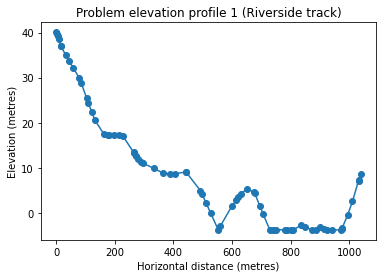

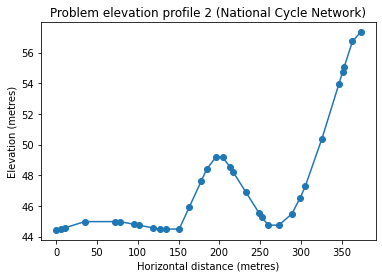

label: slp+cont+weakpitch2
smp: 2.0408163265306123
slope: 2.66
cont: 2.66
ang: 2.56
R: 0.9884029011072466
loglik: -3444.226734179797
coeff: 1.0069485156831801
int: 0.20012359043171912
ec/len err: 0.006069455676681603
min outlier: -36.35175432166082
max outlier: 24.43770642380204
riverside ec: 78.50898254582846
ncn ec: 22.752439403825484


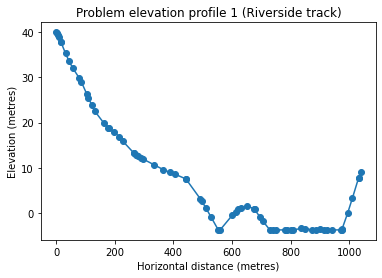

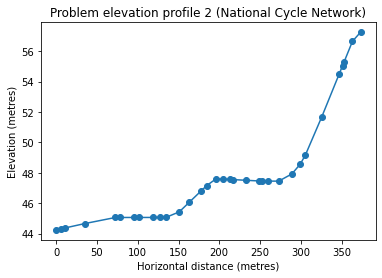

label: slp+cont+weakpitch2
smp: 3.4489795918367347
slope: 2.66
cont: 2.66
ang: 2.56
R: 0.987921103340521
loglik: -3472.5505174743694
coeff: 1.0247546723351304
int: 0.30440594086319805
ec/len err: 0.00629237909633405
min outlier: -35.05576609979154
max outlier: 32.67112039976057
riverside ec: 68.4615348942488
ncn ec: 13.276902566025207


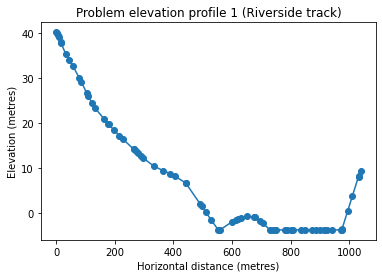

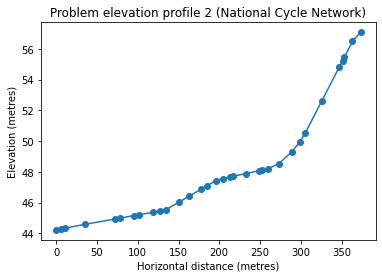

label: slp+cont+weakpitch2
smp: 5.224489795918367
slope: 2.66
cont: 2.66
ang: 2.56
R: 0.9865333301231817
loglik: -3548.1921926223504
coeff: 1.034777917230123
int: 0.38850695471744245
ec/len err: 0.006653797477870441
min outlier: -35.861509720354235
max outlier: 36.93084916007985
riverside ec: 63.08960716919377
ncn ec: 12.861062777618955


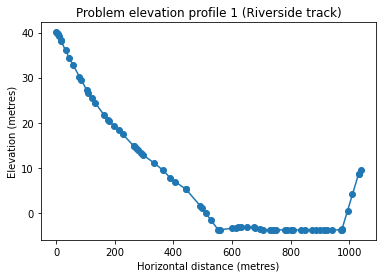

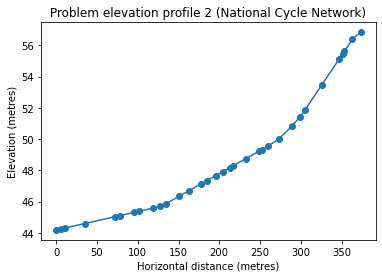

label: slp+cont+weakpitch2
smp: 7.367346938775511
slope: 2.66
cont: 2.66
ang: 2.56
R: 0.9841527565947608
loglik: -3661.2973236241205
coeff: 1.0456352361554928
int: 0.5223571232224131
ec/len err: 0.007264159890753652
min outlier: -36.36458242940253
max outlier: 40.747539947287095
riverside ec: 58.426457183873
ncn ec: 12.656141138701344


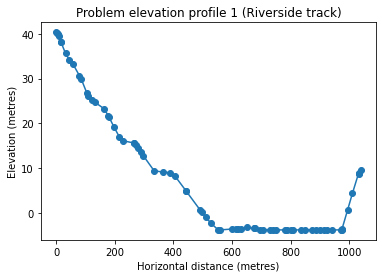

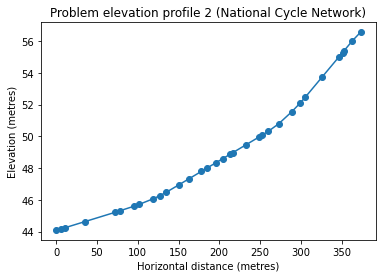

label: slp+cont+weakpitch2
smp: 9.877551020408163
slope: 2.66
cont: 2.66
ang: 2.56
R: 0.9849555640218083
loglik: -3625.1893501142613
coeff: 1.0425294872698017
int: 0.48863744905841244
ec/len err: 0.007081557165114824
min outlier: -36.4057427837395
max outlier: 38.958835538417304
riverside ec: 58.729156241118055
ncn ec: 12.44518086102034


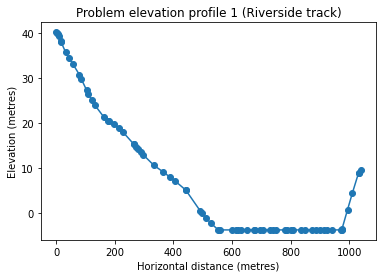

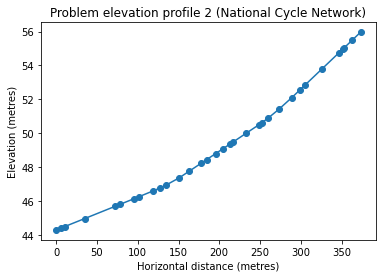

label: slp+cont+weakpitch2
smp: 12.755102040816325
slope: 2.66
cont: 2.66
ang: 2.56
R: 0.9842377864779251
loglik: -3657.561292384262
coeff: 1.0453936448634702
int: 0.5215482542501526
ec/len err: 0.007253111502193348
min outlier: -36.49522333718615
max outlier: 40.39705809005085
riverside ec: 57.628798761696856
ncn ec: 11.648024670093193


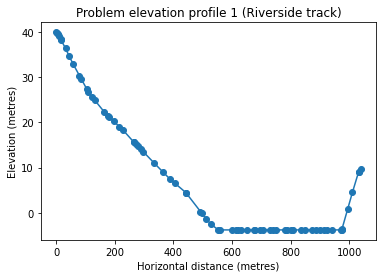

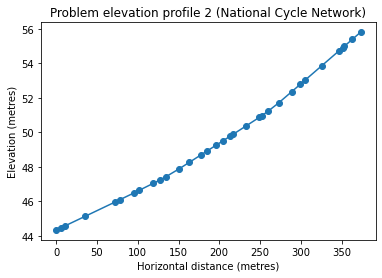

label: slp+cont+weakpitch2
smp: 16.0
slope: 2.66
cont: 2.66
ang: 2.56
R: 0.9828701339796918
loglik: -3715.324220310572
coeff: 1.0498237019092465
int: 0.5902265102138458
ec/len err: 0.00760469689062982
min outlier: -36.684751401733465
max outlier: 44.98223670723738
riverside ec: 57.331448409873424
ncn ec: 11.459210777862161


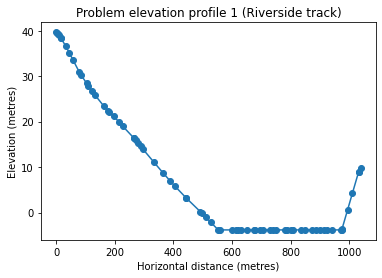

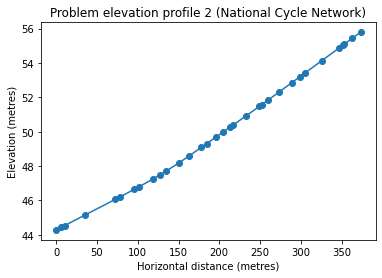

label: slp+cont+weakpitch2
smp: 19.612244897959187
slope: 2.66
cont: 2.66
ang: 2.56
R: 0.981186449758023
loglik: -3780.3573012806582
coeff: 1.05359756316222
int: 0.6912422312977853
ec/len err: 0.008068195427852474
min outlier: -36.645775049631155
max outlier: 49.29773588633722
riverside ec: 57.0803604162871
ncn ec: 11.494905844364915


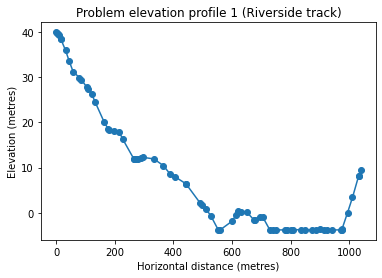

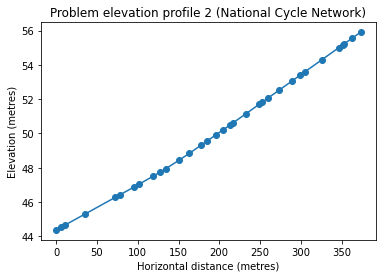

label: slp+cont+weakpitch2
smp: 23.591836734693874
slope: 2.66
cont: 2.66
ang: 2.56
R: 0.9877204422853026
loglik: -3484.0130930094447
coeff: 1.0270242456354173
int: 0.33853681051598805
ec/len err: 0.006386176499833396
min outlier: -35.5145910087337
max outlier: 33.992445042086366
riverside ec: 67.70561647334375
ncn ec: 11.522751622337104


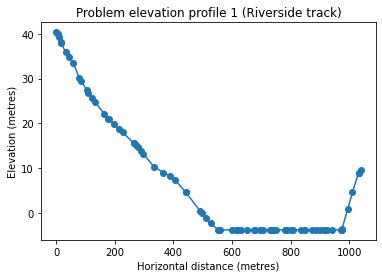

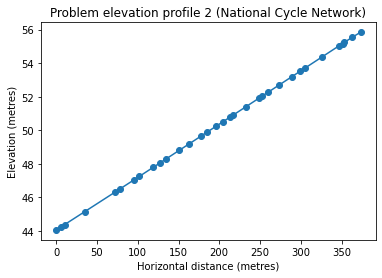

label: slp+cont+weakpitch2
smp: 27.93877551020408
slope: 2.66
cont: 2.66
ang: 2.56
R: 0.9840152020906054
loglik: -3667.29859400171
coeff: 1.0457989013907067
int: 0.5394880559654229
ec/len err: 0.007329706835521046
min outlier: -36.65567321467738
max outlier: 41.01744428283584
riverside ec: 57.59852866765053
ncn ec: 11.770574697504244


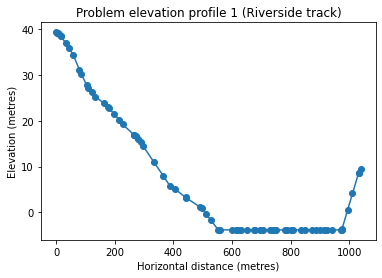

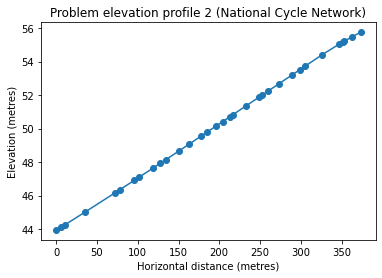

label: slp+cont+weakpitch2
smp: 32.6530612244898
slope: 2.66
cont: 2.66
ang: 2.56
R: 0.9798607632368822
loglik: -3827.5535836841545
coeff: 1.0581287498740317
int: 0.7625726161537827
ec/len err: 0.008432842037927726
min outlier: -36.8231048411007
max outlier: 51.34184253308166
riverside ec: 56.335440302981354
ncn ec: 11.793320659514393


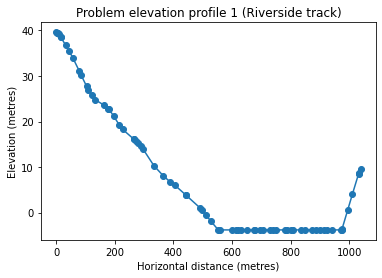

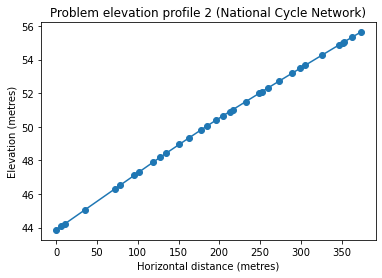

label: slp+cont+weakpitch2
smp: 37.73469387755102
slope: 2.66
cont: 2.66
ang: 2.56
R: 0.981148970215508
loglik: -3781.7371813255304
coeff: 1.053881653551021
int: 0.695707353754841
ec/len err: 0.008073260583515502
min outlier: -36.96170565923421
max outlier: 48.62206841057295
riverside ec: 56.69734326597233
ncn ec: 11.760875660384364


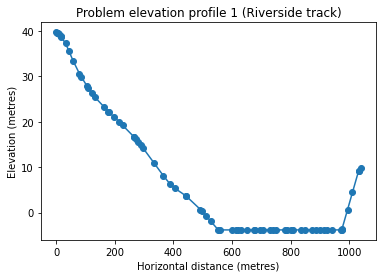

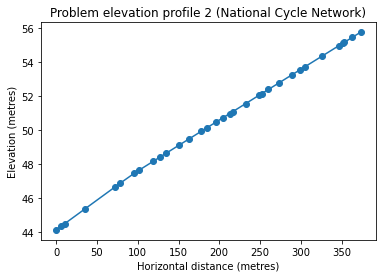

label: slp+cont+weakpitch2
smp: 43.18367346938775
slope: 2.66
cont: 2.66
ang: 2.56
R: 0.9811341590935201
loglik: -3782.2817172350806
coeff: 1.0546325592270556
int: 0.7150122355344557
ec/len err: 0.008154211874203213
min outlier: -36.61353203863463
max outlier: 47.897560986555334
riverside ec: 56.98502971943937
ncn ec: 11.64261303888501


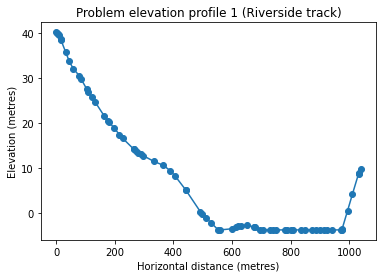

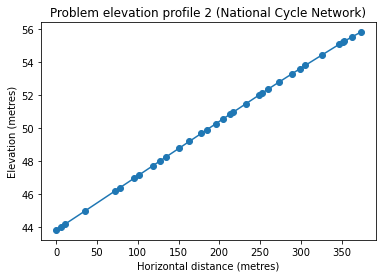

label: slp+cont+weakpitch2
smp: 49.0
slope: 2.66
cont: 2.66
ang: 2.56
R: 0.9859012762113758
loglik: -3580.0760216925382
coeff: 1.0390892754855088
int: 0.4436287751175385
ec/len err: 0.006875352322607866
min outlier: -36.0420686242735
max outlier: 37.515208851825
riverside ec: 59.69027802645761
ncn ec: 11.970868473582868


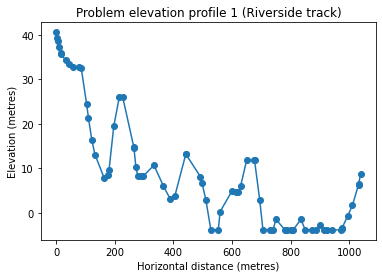

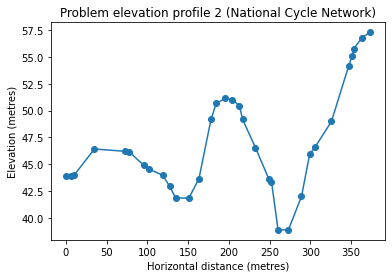

label: slope2
smp: 1.0
slope: 2.66
cont: inf
ang: inf
R: 0.9684555218727597
loglik: -4137.619479336125
coeff: 0.91835883797879
int: 0.6078539277980237
ec/len err: 0.008204448405231667
min outlier: -89.85387062647322
max outlier: 15.386410298765284
riverside ec: 161.751605750982
ncn ec: 47.05874473194392


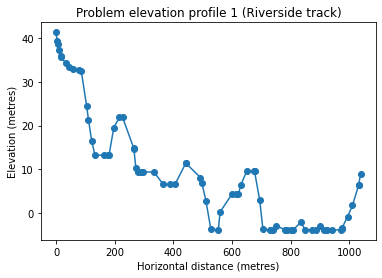

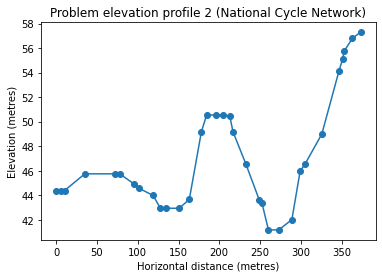

label: slope2
smp: 2.0408163265306123
slope: 2.66
cont: inf
ang: inf
R: 0.9830654967143347
loglik: -3707.3639495455295
coeff: 0.9787369812228638
int: 0.3129372198331808
ec/len err: 0.006591678966836452
min outlier: -57.316638737531356
max outlier: 16.868239001404163
riverside ec: 118.83039442566562
ncn ec: 37.27883379023834


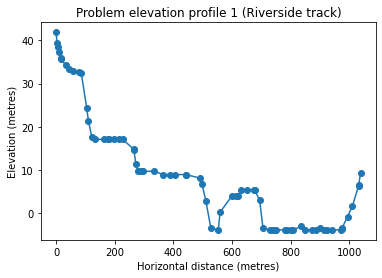

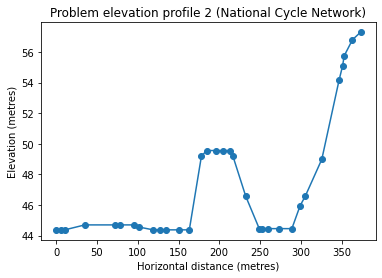

label: slope2
smp: 3.4489795918367347
slope: 2.66
cont: inf
ang: inf
R: 0.9871821647842106
loglik: -3513.8546767217367
coeff: 1.0178058838206743
int: 0.346879402827712
ec/len err: 0.006447173219944547
min outlier: -34.164604679542805
max outlier: 28.24601210540517
riverside ec: 80.10174520111649
ncn ec: 23.788122221282215


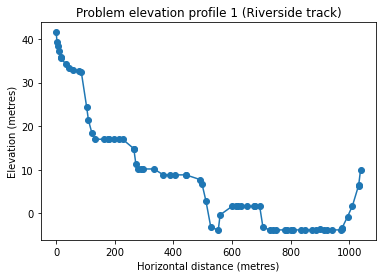

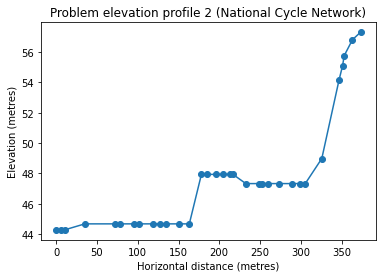

label: slope2
smp: 5.224489795918367
slope: 2.66
cont: inf
ang: inf
R: 0.984168688928562
loglik: -3660.5988318607806
coeff: 1.0362094482347217
int: 0.579290555357268
ec/len err: 0.007358555936477907
min outlier: -35.35294743748716
max outlier: 37.5281214370527
riverside ec: 70.23287944590817
ncn ec: 14.21863404331399


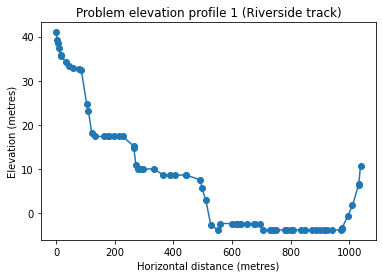

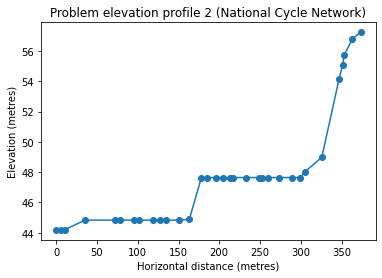

label: slope2
smp: 7.367346938775511
slope: 2.66
cont: inf
ang: inf
R: 0.9798469818676115
loglik: -3828.027560415338
coeff: 1.0494737119475661
int: 0.8569503120393112
ec/len err: 0.008556324955543707
min outlier: -35.89973092314976
max outlier: 48.92961702632152
riverside ec: 62.252527290060236
ncn ec: 13.057321595788046


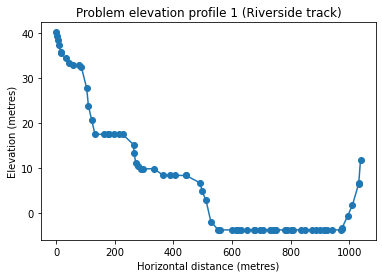

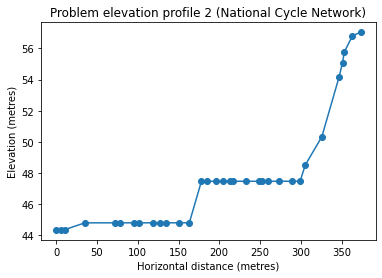

label: slope2
smp: 9.877551020408163
slope: 2.66
cont: inf
ang: inf
R: 0.9751147881754088
loglik: -3973.996195407029
coeff: 1.0588076544598009
int: 1.1287693842721644
ec/len err: 0.009728285427790539
min outlier: -35.829462461260064
max outlier: 59.511939182921765
riverside ec: 59.56433985695354
ncn ec: 12.677041826681055


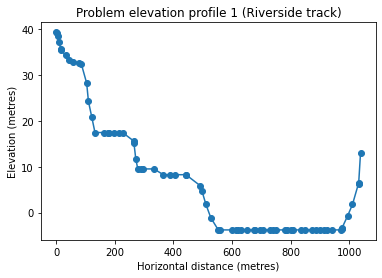

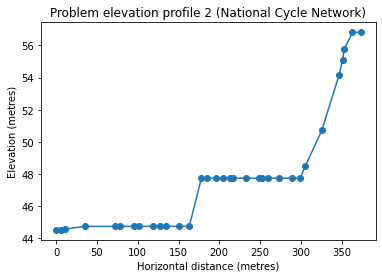

label: slope2
smp: 12.755102040816325
slope: 2.66
cont: inf
ang: inf
R: 0.9694426547426827
loglik: -4115.715000149845
coeff: 1.0650871337114702
int: 1.3977676555161533
ec/len err: 0.010938709973048211
min outlier: -35.339156192727515
max outlier: 70.08845380530468
riverside ec: 60.00222245774734
ncn ec: 12.281771252918112


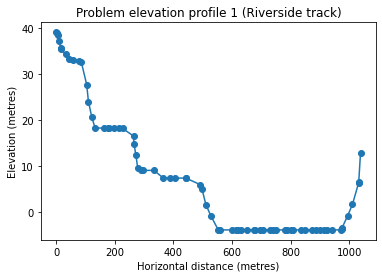

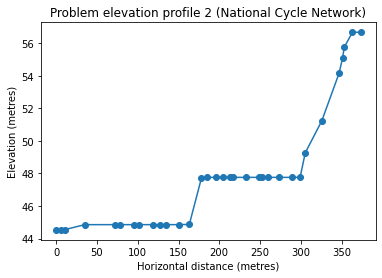

label: slope2
smp: 16.0
slope: 2.66
cont: inf
ang: inf
R: 0.9645409879275316
loglik: -4218.111271053638
coeff: 1.0679946764365262
int: 1.6537192112175418
ec/len err: 0.012017728490268166
min outlier: -34.65403826086205
max outlier: 75.74589915264033
riverside ec: 59.74142496550652
ncn ec: 12.145130963735149


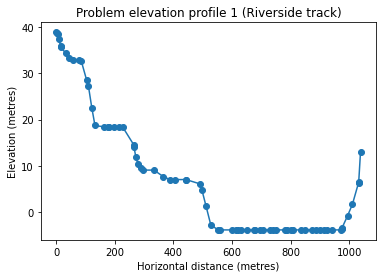

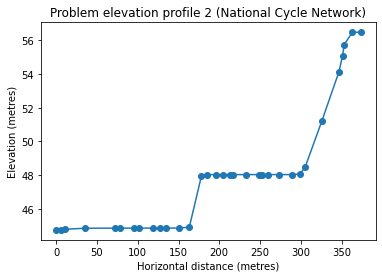

label: slope2
smp: 19.612244897959187
slope: 2.66
cont: inf
ang: inf
R: 0.9584281457333758
loglik: -4327.261906466829
coeff: 1.0704141940783443
int: 1.9627156633603597
ec/len err: 0.01334770859654808
min outlier: -33.5235472456919
max outlier: 81.70711139116045
riverside ec: 59.47157822797456
ncn ec: 11.746089169223659


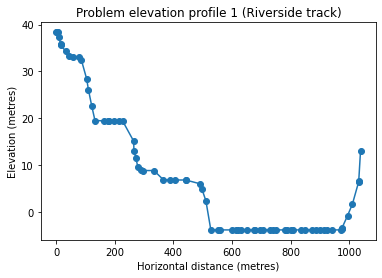

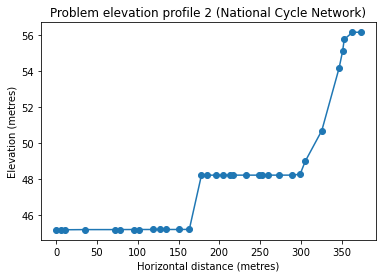

label: slope2
smp: 23.591836734693874
slope: 2.66
cont: inf
ang: inf
R: 0.9510258821902643
loglik: -4439.319121019975
coeff: 1.0718871768854135
int: 2.2748238495742132
ec/len err: 0.014696947546220947
min outlier: -32.16225005929063
max outlier: 88.42885272282507
riverside ec: 59.04606836039408
ncn ec: 11.00610109005153


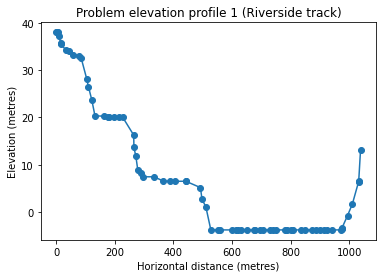

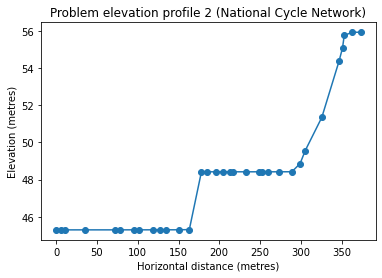

label: slope2
smp: 27.93877551020408
slope: 2.66
cont: inf
ang: inf
R: 0.944983083279321
loglik: -4518.59182215478
coeff: 1.0719304141651507
int: 2.4951343270008177
ec/len err: 0.01565451120052991
min outlier: -31.16723907829744
max outlier: 93.7254258640163
riverside ec: 58.74531587720453
ncn ec: 10.625775400643661


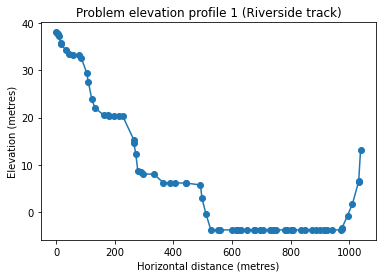

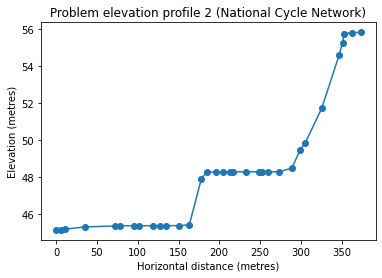

label: slope2
smp: 32.6530612244898
slope: 2.66
cont: inf
ang: inf
R: 0.9350995788402013
loglik: -4630.675056337149
coeff: 1.0709253089014394
int: 2.8045209415978363
ec/len err: 0.016999286176139265
min outlier: -30.338027395575065
max outlier: 103.25131194290063
riverside ec: 58.78017764614521
ncn ec: 10.6967364569321


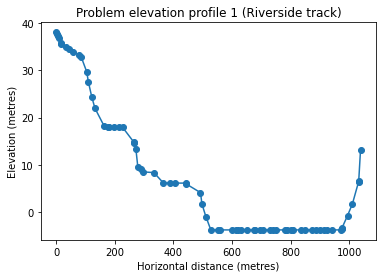

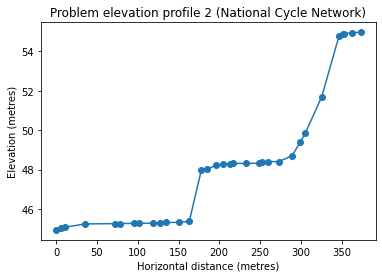

label: slope2
smp: 37.73469387755102
slope: 2.66
cont: inf
ang: inf
R: 0.9294148483398232
loglik: -4687.391629092181
coeff: 1.0702430368950295
int: 2.9710908329415027
ec/len err: 0.01772120261301504
min outlier: -30.4211602650882
max outlier: 108.55391218832241
riverside ec: 58.842504291749904
ncn ec: 10.025636951991437


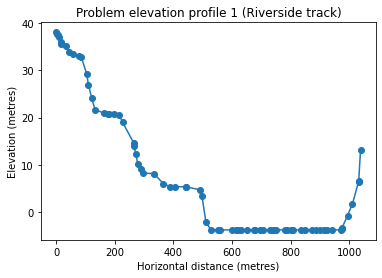

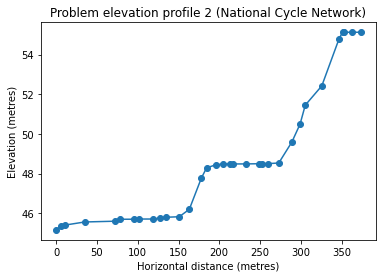

label: slope2
smp: 43.18367346938775
slope: 2.66
cont: inf
ang: inf
R: 0.9161020728984823
loglik: -4803.491727169949
coeff: 1.066569048243851
int: 3.3356126134248107
ec/len err: 0.019308667822028967
min outlier: -30.469684221851704
max outlier: 120.97931808018856
riverside ec: 58.80263417625015
ncn ec: 9.966254855981305


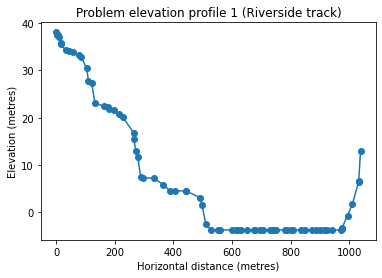

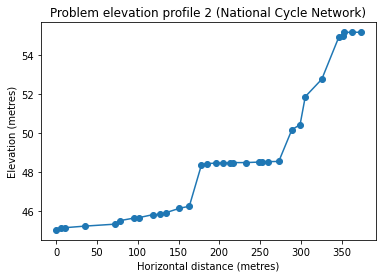

label: slope2
smp: 49.0
slope: 2.66
cont: inf
ang: inf
R: 0.9149939528217894
loglik: -4812.271829681391
coeff: 1.0659513275298746
int: 3.374653068063701
ec/len err: 0.01945584073051864
min outlier: -30.53793951199091
max outlier: 121.35213754428918
riverside ec: 58.665648753740605
ncn ec: 10.151425041182172


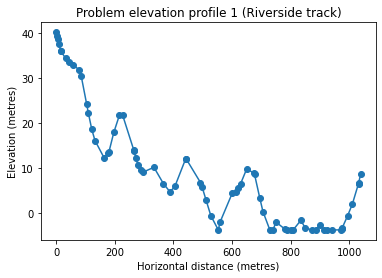

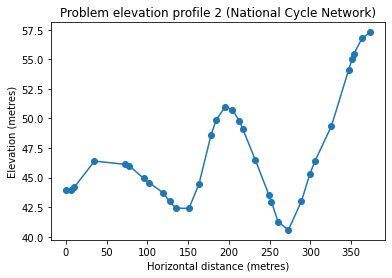

label: cont2
smp: 1.0
slope: 90
cont: 2.66
ang: inf
R: 0.9767068670931927
loglik: -3928.279623840278
coeff: 0.9343980309685731
int: 0.40386371630274454
ec/len err: 0.007580767811830047
min outlier: -62.04491145691697
max outlier: 14.068394952833412
riverside ec: 129.4320447307127
ncn ec: 42.24873242344281


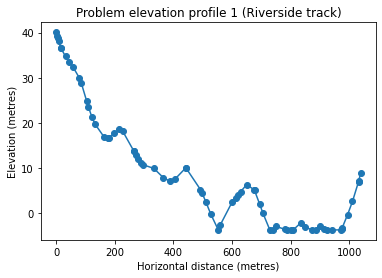

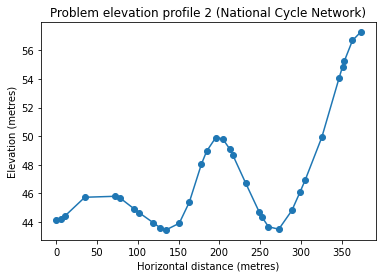

label: cont2
smp: 2.0408163265306123
slope: 90
cont: 2.66
ang: inf
R: 0.9866835497364146
loglik: -3540.3928026371173
coeff: 0.9843210582504991
int: 0.18006203937475718
ec/len err: 0.006296014392764781
min outlier: -40.07673034628958
max outlier: 18.04858385446248
riverside ec: 92.86949016719689
ncn ec: 30.686038478764466


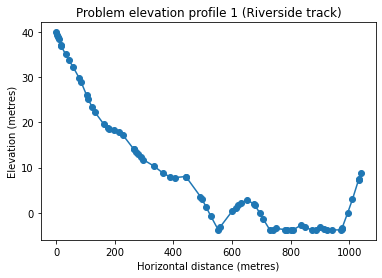

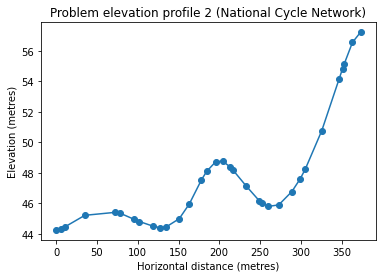

label: cont2
smp: 3.4489795918367347
slope: 90
cont: 2.66
ang: inf
R: 0.9886260290578954
loglik: -3430.7060459480535
coeff: 1.01724421461884
int: 0.19770055053549918
ec/len err: 0.006091675294723425
min outlier: -35.87997141768232
max outlier: 27.822209111053283
riverside ec: 74.24589425204294
ncn ec: 20.86695436196502


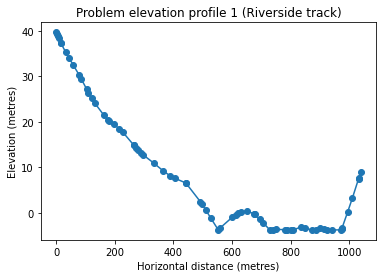

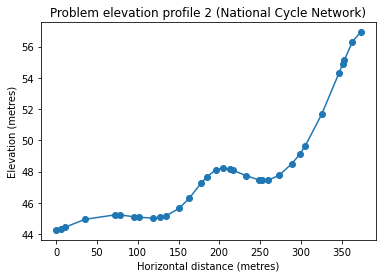

label: cont2
smp: 5.224489795918367
slope: 90
cont: 2.66
ang: inf
R: 0.9870242177582239
loglik: -3522.3720332866214
coeff: 1.0388249998209391
int: 0.32710221249567084
ec/len err: 0.006642182119664401
min outlier: -35.35790441089566
max outlier: 34.53686010002771
riverside ec: 67.17727478318332
ncn ec: 14.630272478702771


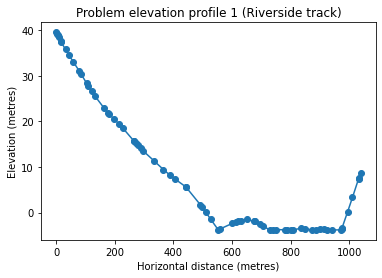

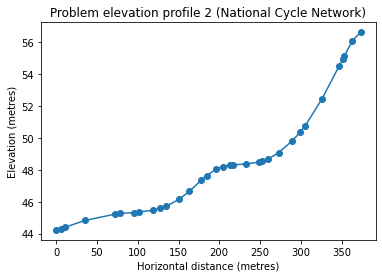

label: cont2
smp: 7.367346938775511
slope: 90
cont: 2.66
ang: inf
R: 0.9840637711548198
loglik: -3665.1855746843403
coeff: 1.053946402411915
int: 0.5045420195527832
ec/len err: 0.007460975754117853
min outlier: -35.741636149127814
max outlier: 41.38393983552763
riverside ec: 61.96612265948487
ncn ec: 12.366402680229697


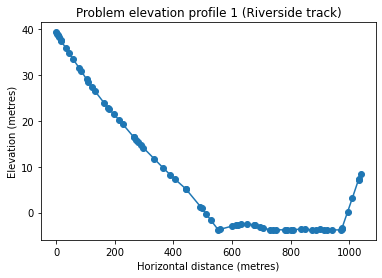

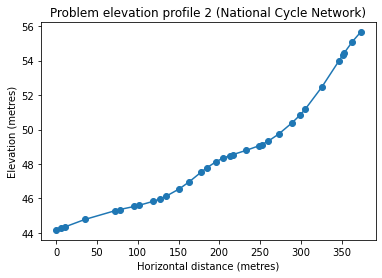

label: cont2
smp: 9.877551020408163
slope: 90
cont: 2.66
ang: inf
R: 0.9799244737264744
loglik: -3825.358148213792
coeff: 1.0669291927441698
int: 0.7086054387975746
ec/len err: 0.008542463299790101
min outlier: -35.834841931343476
max outlier: 50.54389378052508
riverside ec: 58.906614103501376
ncn ec: 11.467278226229602


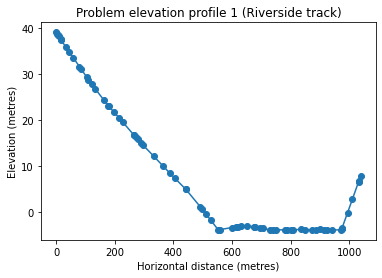

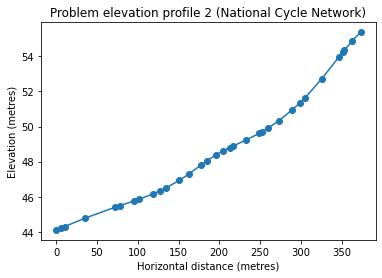

label: cont2
smp: 12.755102040816325
slope: 90
cont: 2.66
ang: inf
R: 0.9747829554297385
loglik: -3983.15107006803
coeff: 1.0785473269914707
int: 0.9214804668724916
ec/len err: 0.009710671199677053
min outlier: -35.689448855745155
max outlier: 60.569423326925886
riverside ec: 56.76484555426384
ncn ec: 11.268460804923883


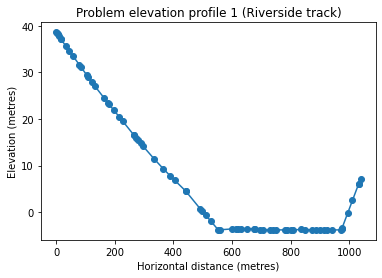

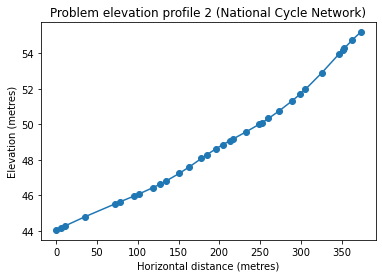

label: cont2
smp: 16.0
slope: 90
cont: 2.66
ang: inf
R: 0.9691751763936782
loglik: -4121.720588885364
coeff: 1.0892891954427284
int: 1.146036754239205
ec/len err: 0.010954160859754664
min outlier: -35.428528001656076
max outlier: 69.35354797915414
riverside ec: 54.33531123797199
ncn ec: 11.122814663442554


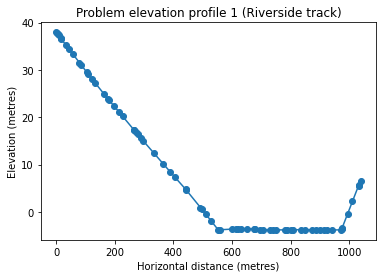

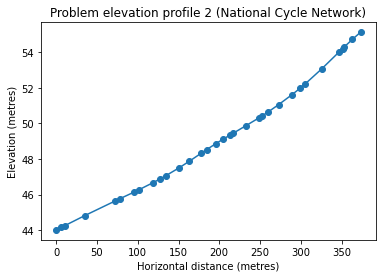

label: cont2
smp: 19.612244897959187
slope: 90
cont: 2.66
ang: inf
R: 0.9629101215226957
loglik: -4249.006596356732
coeff: 1.0993692542940088
int: 1.3684851704036163
ec/len err: 0.012184312302186095
min outlier: -35.19526778088152
max outlier: 78.93973548901909
riverside ec: 52.916602577041544
ncn ec: 11.096025399274872


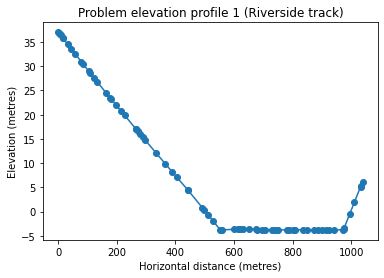

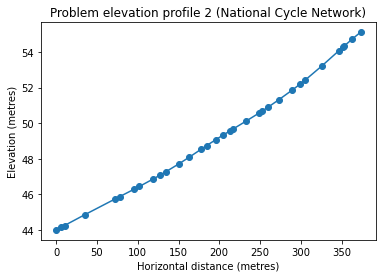

label: cont2
smp: 23.591836734693874
slope: 90
cont: 2.66
ang: inf
R: 0.9555205149886221
loglik: -4373.545160814386
coeff: 1.1091637616428351
int: 1.5990583437011665
ec/len err: 0.013474775719424587
min outlier: -34.8911704496154
max outlier: 88.98186841938067
riverside ec: 51.3387439805779
ncn ec: 11.093318912403099


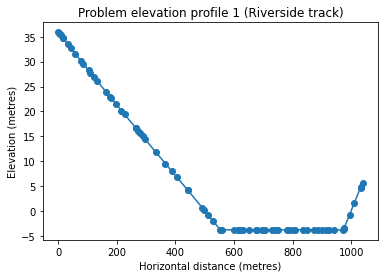

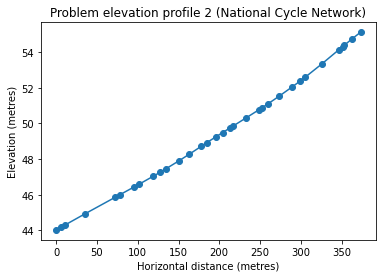

label: cont2
smp: 27.93877551020408
slope: 90
cont: 2.66
ang: inf
R: 0.9471663581602446
loglik: -4491.032343193001
coeff: 1.118922042408494
int: 1.8424398541046791
ec/len err: 0.014811452390404063
min outlier: -34.65150353062805
max outlier: 98.36504925359253
riverside ec: 49.42414610691021
ncn ec: 11.107097476921133


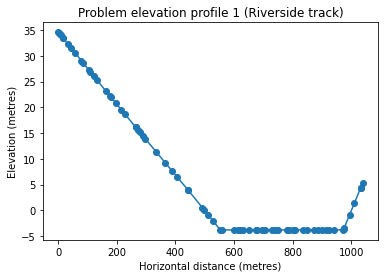

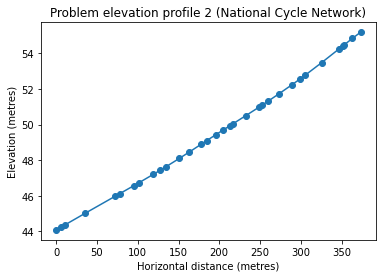

label: cont2
smp: 32.6530612244898
slope: 90
cont: 2.66
ang: inf
R: 0.9369432784517966
loglik: -4611.168061150033
coeff: 1.1278347498782988
int: 2.1127261998242055
ec/len err: 0.01622087852294983
min outlier: -34.319077729990624
max outlier: 107.40915522016476
riverside ec: 47.49254564895941
ncn ec: 11.106624451594513


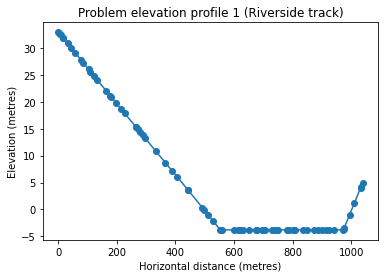

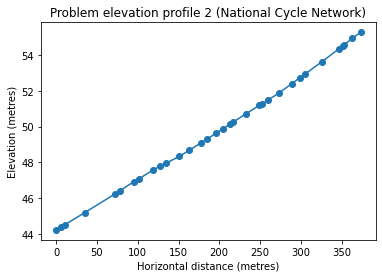

label: cont2
smp: 37.73469387755102
slope: 90
cont: 2.66
ang: inf
R: 0.9268059322622534
loglik: -4711.850661539743
coeff: 1.1369201848796162
int: 2.3663434134337926
ec/len err: 0.0174788527626027
min outlier: -33.92512500049624
max outlier: 115.9809006799234
riverside ec: 45.60317558961862
ncn ec: 11.03825339302928


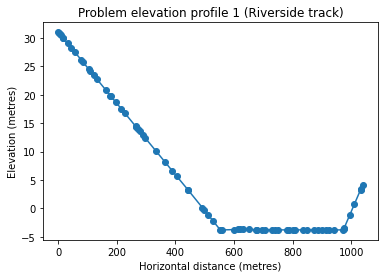

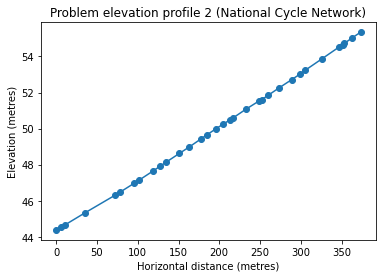

label: cont2
smp: 43.18367346938775
slope: 90
cont: 2.66
ang: inf
R: 0.9163611446222876
loglik: -4801.421464228825
coeff: 1.1449264020364003
int: 2.6221654900947513
ec/len err: 0.018724851182062102
min outlier: -33.39641133162203
max outlier: 125.23966780959267
riverside ec: 42.933041970424554
ncn ec: 10.96253389030764


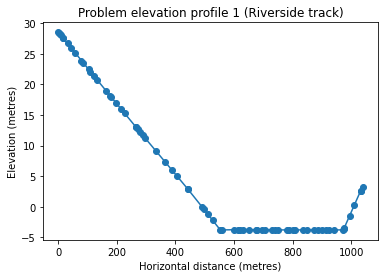

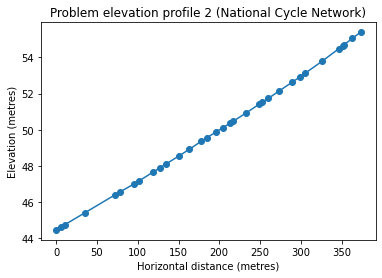

label: cont2
smp: 49.0
slope: 90
cont: 2.66
ang: inf
R: 0.905885081006588
loglik: -4880.190187968836
coeff: 1.1510652395955896
int: 2.872378882051196
ec/len err: 0.019874312197806415
min outlier: -33.075703687929575
max outlier: 133.50438849860024
riverside ec: 39.51486949791025
ncn ec: 10.918937654161184


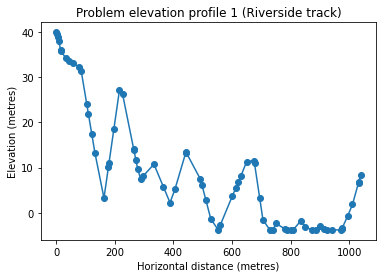

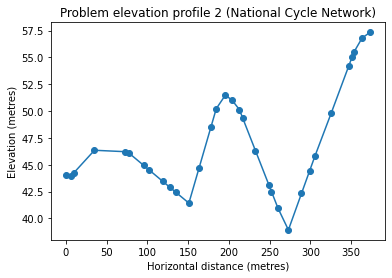

label: pitch2
smp: 1.0
slope: 90
cont: inf
ang: 1.28
R: 0.9670512547596956
loglik: -4167.608169364077
coeff: 0.9107606470616039
int: 0.678264670089316
ec/len err: 0.008423841886737431
min outlier: -98.11685624272883
max outlier: 15.458483240741177
riverside ec: 172.09635932154822
ncn ec: 48.54977518689392


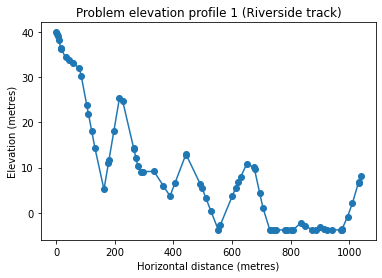

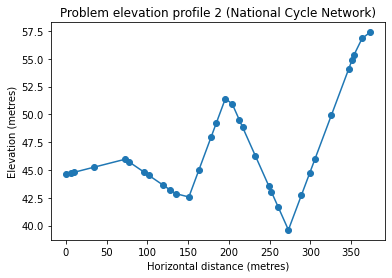

label: pitch2
smp: 2.0408163265306123
slope: 90
cont: inf
ang: 1.28
R: 0.9754841947769324
loglik: -3963.658111879683
coeff: 0.9394229218281105
int: 0.48867035278225046
ec/len err: 0.007488267411939112
min outlier: -80.86479171080555
max outlier: 15.332883026491633
riverside ec: 148.68289682160886
ncn ec: 43.194900074151356


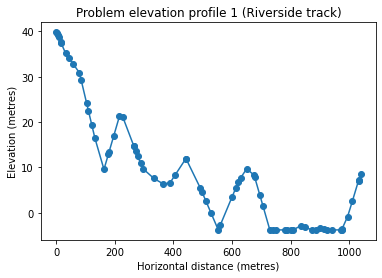

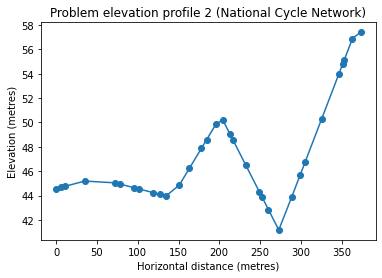

label: pitch2
smp: 3.4489795918367347
slope: 90
cont: inf
ang: 1.28
R: 0.9824637835515329
loglik: -3731.5920882862065
coeff: 0.9702619782907804
int: 0.3221414777681417
ec/len err: 0.006624823533122067
min outlier: -57.54082861902207
max outlier: 15.942606960547664
riverside ec: 120.0899239054116
ncn ec: 33.35267374646972


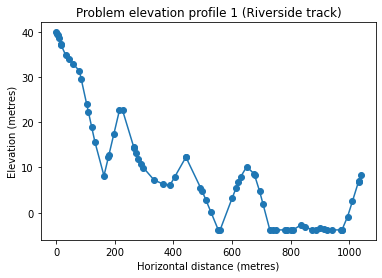

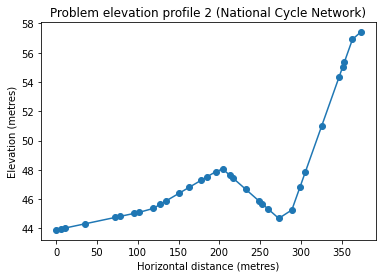

label: pitch2
smp: 5.224489795918367
slope: 90
cont: inf
ang: 1.28
R: 0.9809282870461706
loglik: -3789.806290989704
coeff: 0.9624470194282317
int: 0.3612520002182613
ec/len err: 0.006820767603737693
min outlier: -64.25521097961712
max outlier: 15.675684804671086
riverside ec: 128.00076938529628
ncn ec: 20.253645599346257


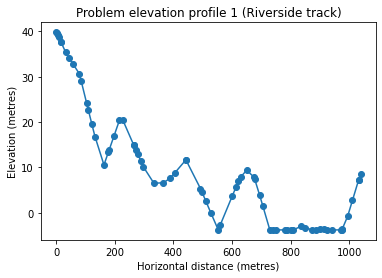

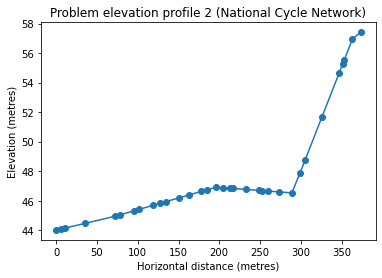

label: pitch2
smp: 7.367346938775511
slope: 90
cont: inf
ang: 1.28
R: 0.9832860729041889
loglik: -3698.2642283025307
coeff: 0.9742542995343908
int: 0.31210831252019666
ec/len err: 0.006536910444136738
min outlier: -52.778584725729395
max outlier: 16.318780071583802
riverside ec: 114.72002378293215
ncn ec: 14.153142710348334


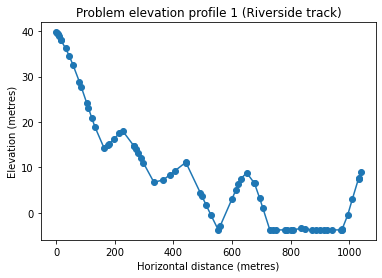

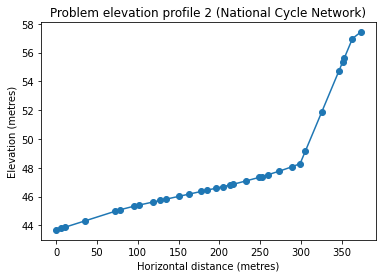

label: pitch2
smp: 9.877551020408163
slope: 90
cont: inf
ang: 1.28
R: 0.9859314492636211
loglik: -3578.5869632709955
coeff: 0.9863659217018687
int: 0.2798297918357253
ec/len err: 0.006263442080057486
min outlier: -41.25524446500671
max outlier: 16.791231209928377
riverside ec: 98.58543565277306
ncn ec: 13.725319108808428


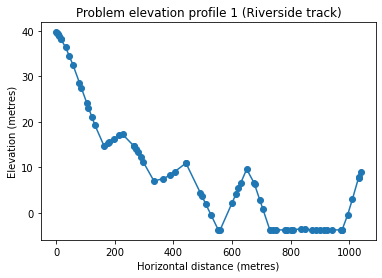

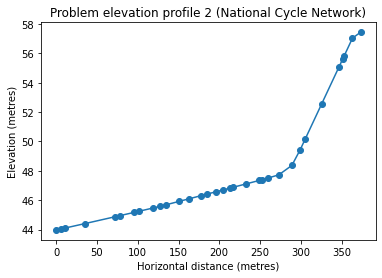

label: pitch2
smp: 12.755102040816325
slope: 90
cont: inf
ang: 1.28
R: 0.9864614486699204
loglik: -3551.8933377558396
coeff: 0.9884581009848994
int: 0.27599836058724847
ec/len err: 0.006209921425301555
min outlier: -40.574808819176496
max outlier: 16.932541520538507
riverside ec: 96.60080134979256
ncn ec: 13.451058130199137


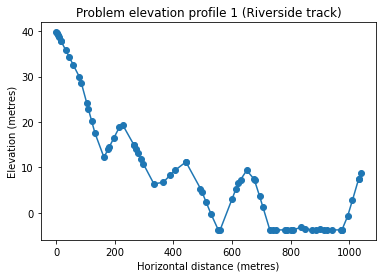

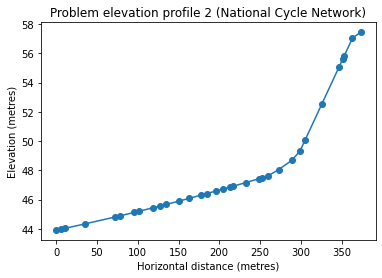

label: pitch2
smp: 16.0
slope: 90
cont: inf
ang: 1.28
R: 0.9847570969113897
loglik: -3634.2934188191066
coeff: 0.9803356689126242
int: 0.2926057601896499
ec/len err: 0.006384413092960265
min outlier: -46.87261415664637
max outlier: 16.470152496071677
riverside ec: 108.0038314977333
ncn ec: 13.511777520667508


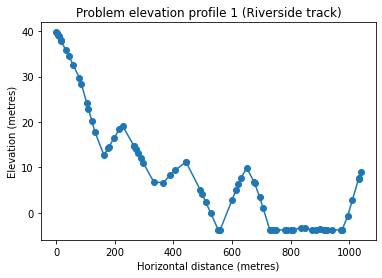

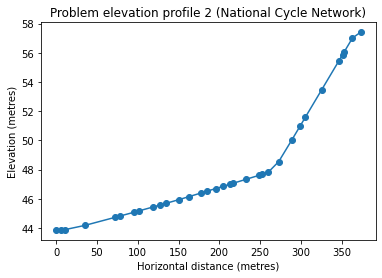

label: pitch2
smp: 19.612244897959187
slope: 90
cont: inf
ang: 1.28
R: 0.9848907937583081
loglik: -3628.1737240998364
coeff: 0.9813823047236223
int: 0.2925420181779508
ec/len err: 0.006368151208006625
min outlier: -45.89098413618253
max outlier: 16.58936909671599
riverside ec: 106.88845887388011
ncn ec: 13.538649087596887


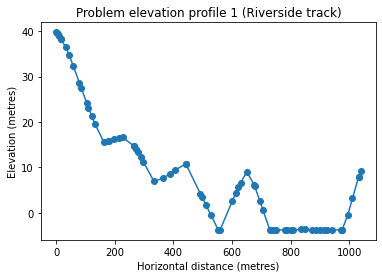

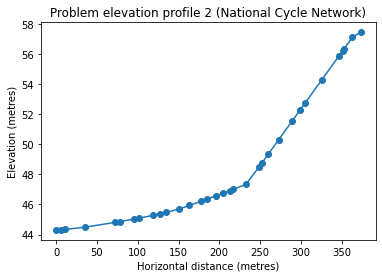

label: pitch2
smp: 23.591836734693874
slope: 90
cont: inf
ang: 1.28
R: 0.9868659050694817
loglik: -3530.8050197644525
coeff: 0.9906229659692635
int: 0.26907195303983755
ec/len err: 0.0061710653061333165
min outlier: -41.015346778194996
max outlier: 16.957340877452793
riverside ec: 92.16590415360012
ncn ec: 13.135150685618171


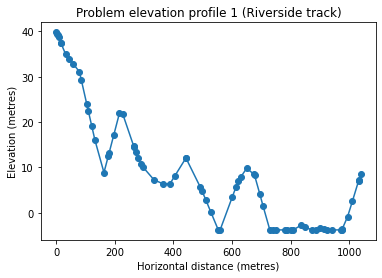

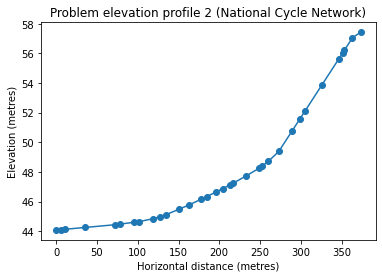

label: pitch2
smp: 27.93877551020408
slope: 90
cont: inf
ang: 1.28
R: 0.9817480693198724
loglik: -3759.3411547766755
coeff: 0.9668586004757806
int: 0.3397167118196034
ec/len err: 0.006716866092438067
min outlier: -60.30817803363673
max outlier: 15.832357918045233
riverside ec: 123.35667414358875
ncn ec: 13.339275123147615


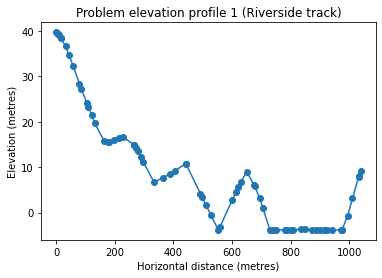

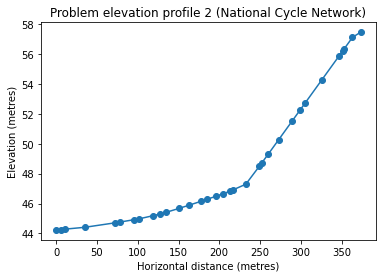

label: pitch2
smp: 32.6530612244898
slope: 90
cont: inf
ang: 1.28
R: 0.9866695492608526
loglik: -3541.123439856623
coeff: 0.989804260847082
int: 0.2773897986428988
ec/len err: 0.006187455287601221
min outlier: -40.71867039451993
max outlier: 16.890459661341303
riverside ec: 92.76950308642961
ncn ec: 13.203767223489038


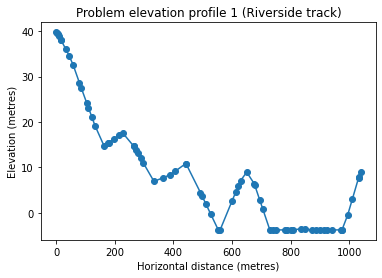

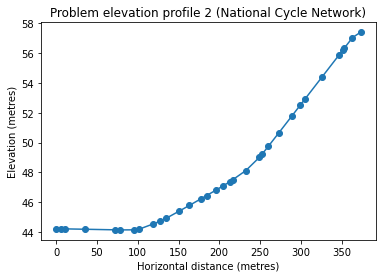

label: pitch2
smp: 37.73469387755102
slope: 90
cont: inf
ang: 1.28
R: 0.9864033707749361
loglik: -3554.8693203782314
coeff: 0.9884325532387878
int: 0.2746332852173108
ec/len err: 0.006224194463548758
min outlier: -41.098251025540364
max outlier: 16.893232316616377
riverside ec: 95.97741358717525
ncn ec: 13.341899433291289


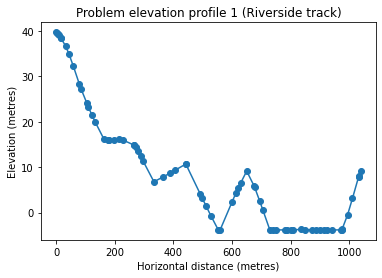

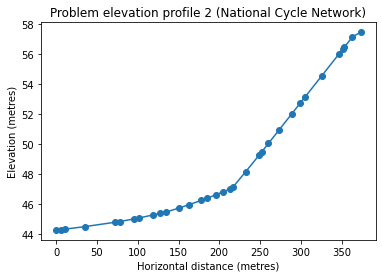

label: pitch2
smp: 43.18367346938775
slope: 90
cont: inf
ang: 1.28
R: 0.9869062885759192
loglik: -3528.6636360594193
coeff: 0.9914116475166934
int: 0.27016233272878587
ec/len err: 0.006148838663329937
min outlier: -40.771817825187306
max outlier: 16.990164763943802
riverside ec: 90.95330887785896
ncn ec: 13.193652519840455


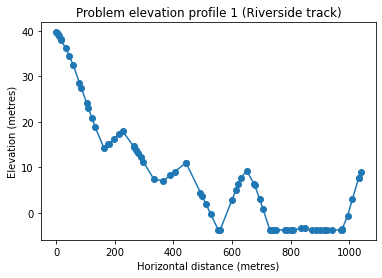

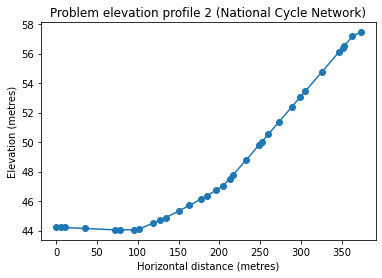

label: pitch2
smp: 49.0
slope: 90
cont: inf
ang: 1.28
R: 0.985910153860542
loglik: -3579.6382378398744
coeff: 0.9864668297874339
int: 0.2775074707237355
ec/len err: 0.006254151394894566
min outlier: -41.27105758879205
max outlier: 16.832030273450876
riverside ec: 98.8063012172052
ncn ec: 13.600670293995861


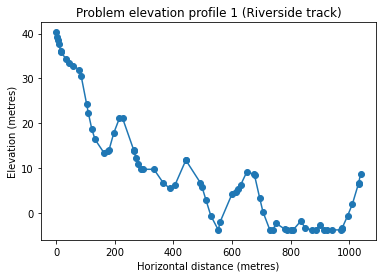

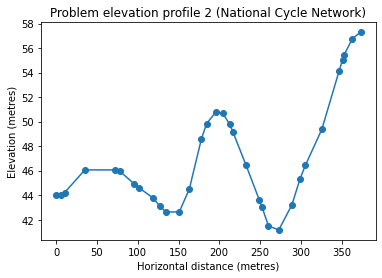

label: slp+cont2
smp: 1.0
slope: 2.66
cont: 2.66
ang: inf
R: 0.9812857416321569
loglik: -3776.6882241498906
coeff: 0.9588144670731846
int: 0.2988774574297377
ec/len err: 0.006920810740826379
min outlier: -55.36513212624144
max outlier: 15.079212696958834
riverside ec: 119.27881628436289
ncn ec: 39.33715249153218


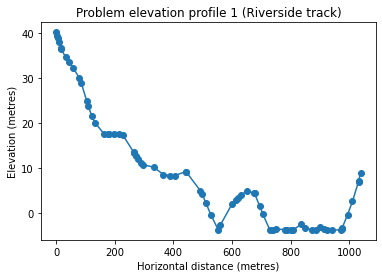

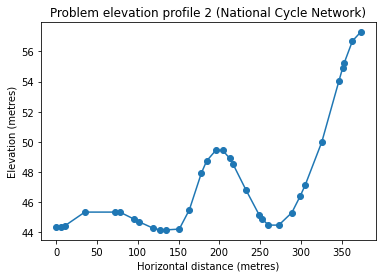

label: slp+cont2
smp: 2.0408163265306123
slope: 2.66
cont: 2.66
ang: inf
R: 0.9882713635039503
loglik: -3452.075336622793
coeff: 1.0108749306907683
int: 0.2199020145510353
ec/len err: 0.006100356371852184
min outlier: -35.418501610919705
max outlier: 25.762575562099812
riverside ec: 80.22415413689613
ncn ec: 25.247425805243175


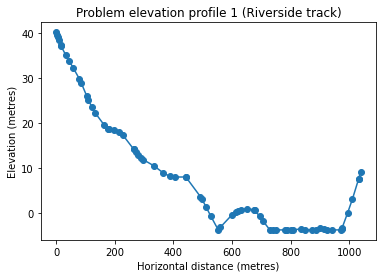

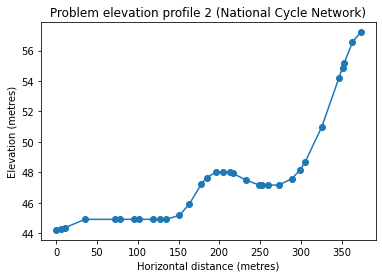

label: slp+cont2
smp: 3.4489795918367347
slope: 2.66
cont: 2.66
ang: inf
R: 0.9861559010713787
loglik: -3567.4081202332627
coeff: 1.0382711362814472
int: 0.4156268417989075
ec/len err: 0.006793329045645189
min outlier: -35.563476548760846
max outlier: 36.600822275301496
riverside ec: 67.38726930844335
ncn ec: 14.660419871455048


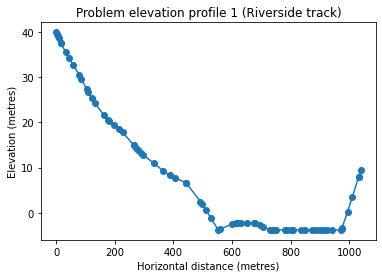

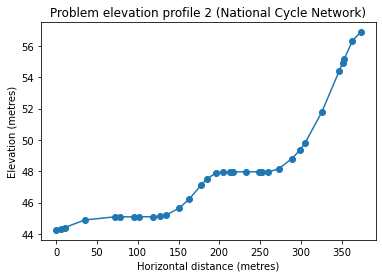

label: slp+cont2
smp: 5.224489795918367
slope: 2.66
cont: 2.66
ang: inf
R: 0.9815034803901331
loglik: -3768.57295893071
coeff: 1.0568270942435023
int: 0.6890977272195524
ec/len err: 0.007988646218143136
min outlier: -36.538190845705856
max outlier: 48.171416917463205
riverside ec: 59.85523157434739
ncn ec: 12.62254349828833


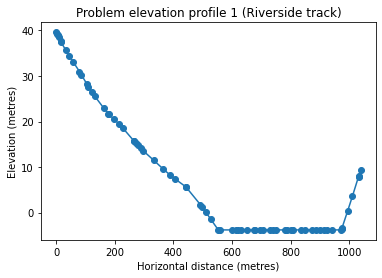

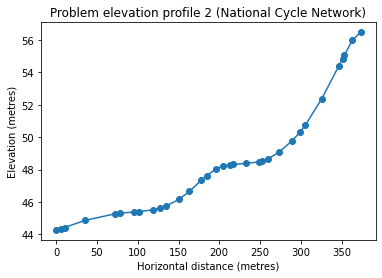

label: slp+cont2
smp: 7.367346938775511
slope: 2.66
cont: 2.66
ang: inf
R: 0.9755664872053855
loglik: -3961.3336221628497
coeff: 1.0687801889249147
int: 1.009917682433752
ec/len err: 0.009421446836948273
min outlier: -36.710206966357006
max outlier: 60.51258309447721
riverside ec: 56.603919721526694
ncn ec: 12.197379233027235


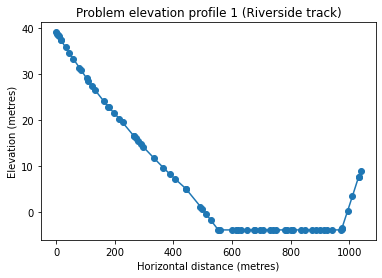

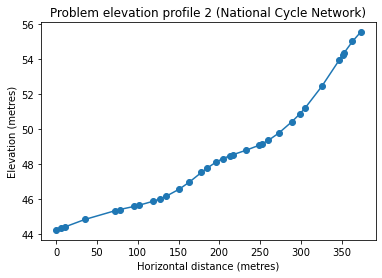

label: slp+cont2
smp: 9.877551020408163
slope: 2.66
cont: 2.66
ang: inf
R: 0.9685919387479505
loglik: -4134.63421235402
coeff: 1.0785120762556608
int: 1.3425980324966247
ec/len err: 0.01096118685562921
min outlier: -36.43136150704362
max outlier: 71.38297154573624
riverside ec: 55.81064980274936
ncn ec: 11.2806253822828


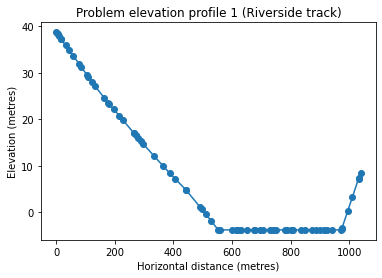

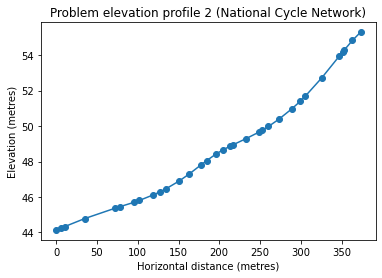

label: slp+cont2
smp: 12.755102040816325
slope: 2.66
cont: 2.66
ang: inf
R: 0.9612699727426798
loglik: -4278.711210434304
coeff: 1.0852913866426275
int: 1.6837538166566226
ec/len err: 0.012526831679779932
min outlier: -35.87151871016653
max outlier: 79.41038180156599
riverside ec: 54.88183088397142
ncn ec: 11.151235963298596


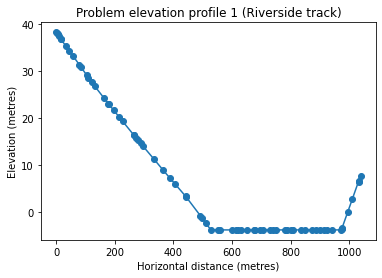

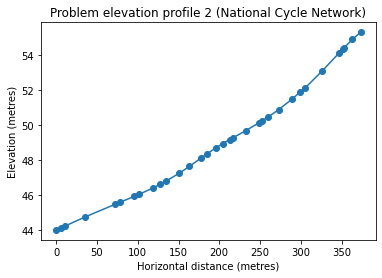

label: slp+cont2
smp: 16.0
slope: 2.66
cont: 2.66
ang: inf
R: 0.9507319705065821
loglik: -4443.402063576743
coeff: 1.0933149323039664
int: 2.0634990404113687
ec/len err: 0.014334503427345179
min outlier: -35.43463746830059
max outlier: 93.79110895717463
riverside ec: 53.545508381628494
ncn ec: 11.289563741118677


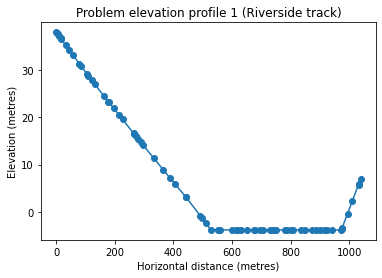

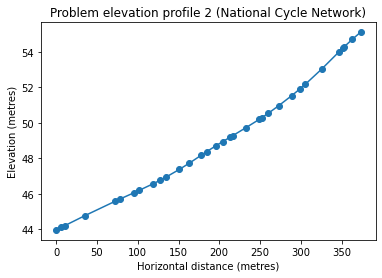

label: slp+cont2
smp: 19.612244897959187
slope: 2.66
cont: 2.66
ang: inf
R: 0.9394846117746904
loglik: -4583.289996327178
coeff: 1.096513870255286
int: 2.431353940768348
ec/len err: 0.016014157119356703
min outlier: -34.66248987000529
max outlier: 106.17409580524046
riverside ec: 52.42180512698078
ncn ec: 11.13899244481668


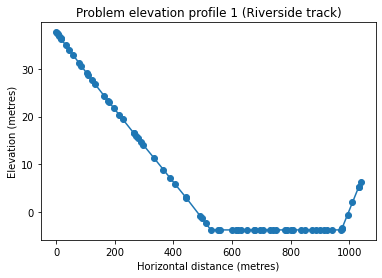

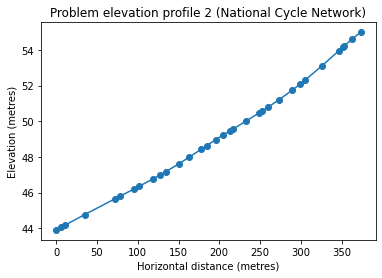

label: slp+cont2
smp: 23.591836734693874
slope: 2.66
cont: 2.66
ang: inf
R: 0.9265791999334579
loglik: -4713.933315345381
coeff: 1.0991158854056555
int: 2.7964609456858245
ec/len err: 0.017677518391505113
min outlier: -33.97951029709981
max outlier: 119.9058896796644
riverside ec: 51.52190262714686
ncn ec: 11.085122411337558


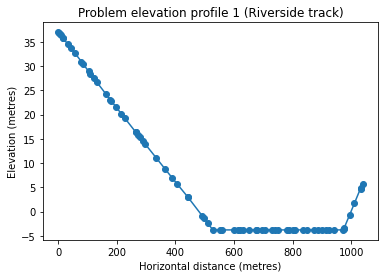

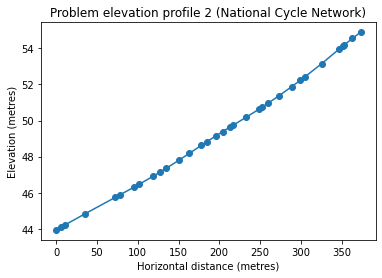

label: slp+cont2
smp: 27.93877551020408
slope: 2.66
cont: 2.66
ang: inf
R: 0.9128107592303779
loglik: -4829.224315982487
coeff: 1.0987366073146012
int: 3.164047910783829
ec/len err: 0.019263381473320584
min outlier: -33.69852731492841
max outlier: 132.59836689017794
riverside ec: 50.368096725525405
ncn ec: 10.940754499490858


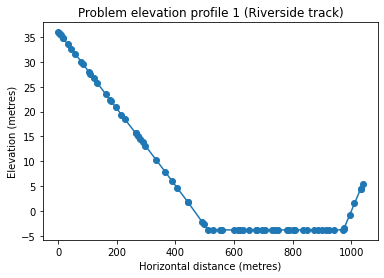

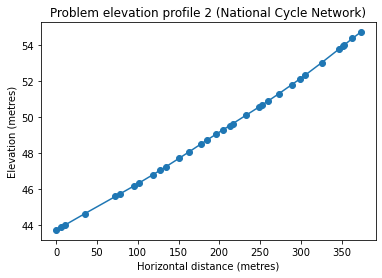

label: slp+cont2
smp: 32.6530612244898
slope: 2.66
cont: 2.66
ang: inf
R: 0.9006386090674294
loglik: -4916.2335159549375
coeff: 1.0961730918746713
int: 3.4847436376411007
ec/len err: 0.02060396251904974
min outlier: -33.1160271266092
max outlier: 140.4928694399543
riverside ec: 48.93728083295284
ncn ec: 11.001638635235956


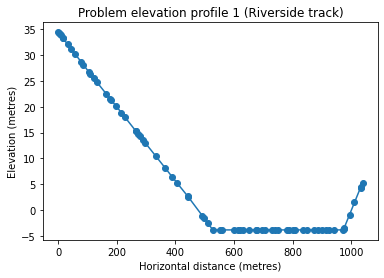

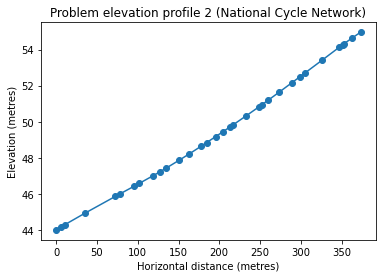

label: slp+cont2
smp: 37.73469387755102
slope: 2.66
cont: 2.66
ang: inf
R: 0.8860240624291905
loglik: -5006.886832561486
coeff: 1.093543074625392
int: 3.829747157875941
ec/len err: 0.02198867975648019
min outlier: -32.76854351079514
max outlier: 149.3086279533151
riverside ec: 47.28407374951196
ncn ec: 10.95510228935354


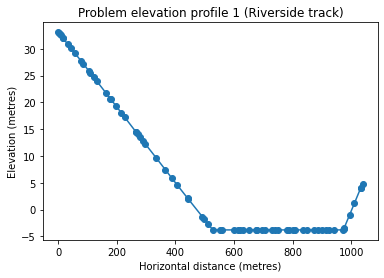

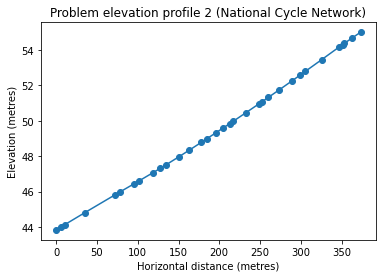

label: slp+cont2
smp: 43.18367346938775
slope: 2.66
cont: 2.66
ang: inf
R: 0.8744787179639344
loglik: -5070.130174333874
coeff: 1.0910496605296842
int: 4.086632491002879
ec/len err: 0.023008191332486713
min outlier: -32.56385328943601
max outlier: 156.3193584569085
riverside ec: 45.54090310604234
ncn ec: 11.176301987085047


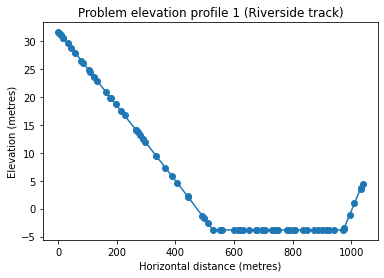

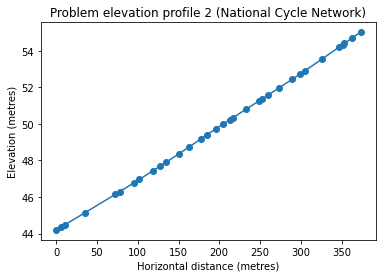

label: slp+cont2
smp: 49.0
slope: 2.66
cont: 2.66
ang: inf
R: 0.8623487598123915
loglik: -5130.159220754122
coeff: 1.0884270688925353
int: 4.3517459188043635
ec/len err: 0.024008696483944124
min outlier: -32.294375938603025
max outlier: 164.10463067302385
riverside ec: 43.564506031172094
ncn ec: 10.818346888993837


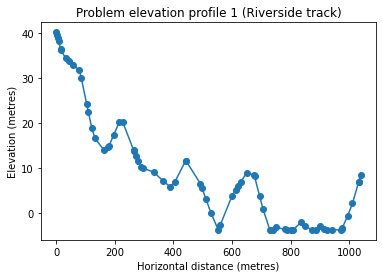

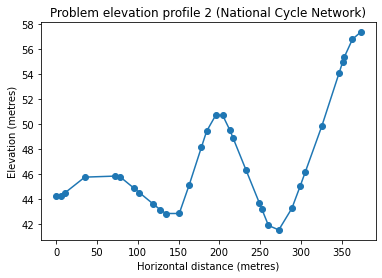

label: all2
smp: 1.0
slope: 2.66
cont: 2.66
ang: 1.28
R: 0.9832382486392243
loglik: -3700.2474279928106
coeff: 0.9664939188759949
int: 0.2668449142792344
ec/len err: 0.006720377950474326
min outlier: -49.29420718970375
max outlier: 15.38236001177664
riverside ec: 112.08281827722845
ncn ec: 37.331552760087064


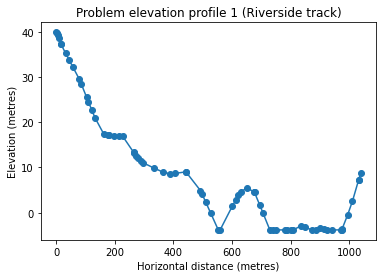

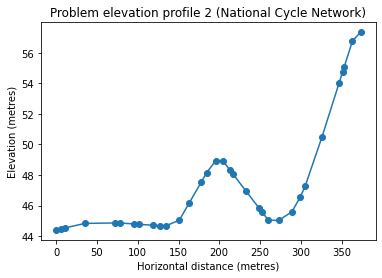

label: all2
smp: 2.0408163265306123
slope: 2.66
cont: 2.66
ang: 1.28
R: 0.988437842224224
loglik: -3442.1268080631758
coeff: 1.0063664566012627
int: 0.20175003885115395
ec/len err: 0.006056031048381552
min outlier: -36.75233233788251
max outlier: 24.061990227284085
riverside ec: 78.23629584304126
ncn ec: 21.114235422023818


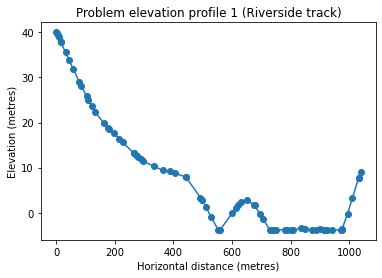

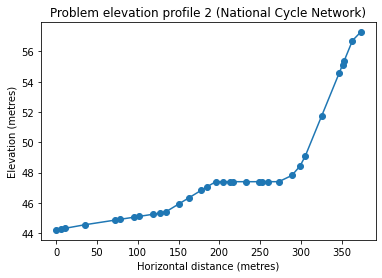

label: all2
smp: 3.4489795918367347
slope: 2.66
cont: 2.66
ang: 1.28
R: 0.9882725045101741
loglik: -3452.0076363640987
coeff: 1.0201649128486154
int: 0.27326653565867076
ec/len err: 0.006173546041011657
min outlier: -34.97893787318199
max outlier: 30.61662359439164
riverside ec: 70.76504044541758
ncn ec: 13.048140287825014


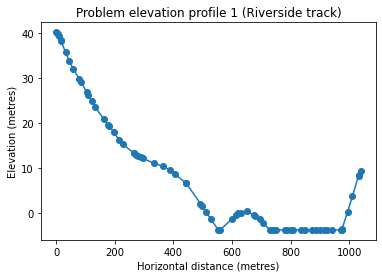

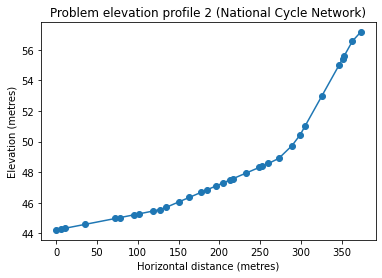

label: all2
smp: 5.224489795918367
slope: 2.66
cont: 2.66
ang: 1.28
R: 0.987498383284699
loglik: -3496.4803353272027
coeff: 1.0282710804373405
int: 0.336908271894778
ec/len err: 0.006397976337484196
min outlier: -35.45523309384495
max outlier: 35.40633851421772
riverside ec: 65.3512876312843
ncn ec: 12.908814192352146


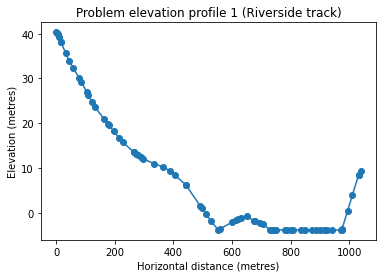

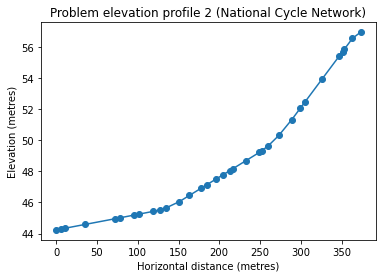

label: all2
smp: 7.367346938775511
slope: 2.66
cont: 2.66
ang: 1.28
R: 0.986725808564347
loglik: -3538.182758729867
coeff: 1.033780070009393
int: 0.3728097765699214
ec/len err: 0.006583530828180316
min outlier: -35.84294341648672
max outlier: 36.86268920445148
riverside ec: 63.412919673082726
ncn ec: 12.711763474099556


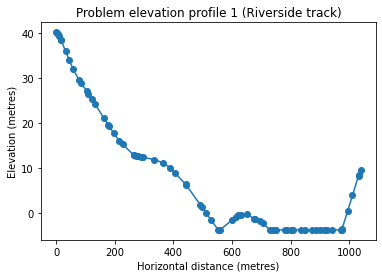

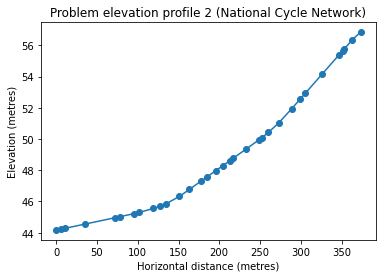

label: all2
smp: 9.877551020408163
slope: 2.66
cont: 2.66
ang: 1.28
R: 0.9873373476248989
loglik: -3505.382866954812
coeff: 1.0301158880987467
int: 0.35157568366655667
ec/len err: 0.00646989229804722
min outlier: -35.56470393808638
max outlier: 35.13682037085243
riverside ec: 64.12242497220447
ncn ec: 12.658408694034947


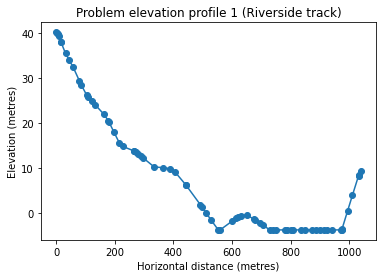

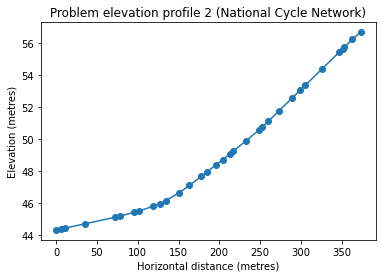

label: all2
smp: 12.755102040816325
slope: 2.66
cont: 2.66
ang: 1.28
R: 0.986956836170084
loglik: -3525.9739008331844
coeff: 1.0320699584456228
int: 0.36278898458889586
ec/len err: 0.006525764090429543
min outlier: -35.77794676652033
max outlier: 36.67855933577208
riverside ec: 63.81880652142984
ncn ec: 12.35756463188416


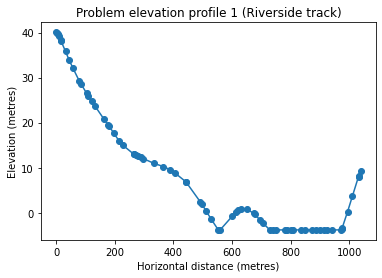

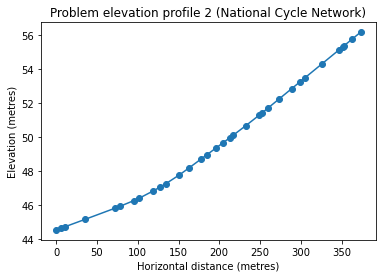

label: all2
smp: 16.0
slope: 2.66
cont: 2.66
ang: 1.28
R: 0.9877020393107282
loglik: -3485.054894109695
coeff: 1.0267087535179582
int: 0.3240461058136841
ec/len err: 0.006349764735765332
min outlier: -35.342247239015165
max outlier: 34.30412604952004
riverside ec: 66.05795717445791
ncn ec: 11.661395165732387


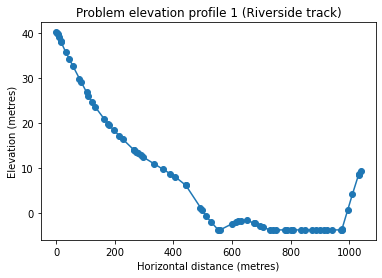

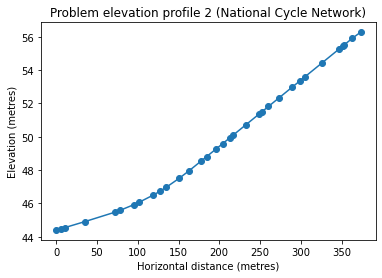

label: all2
smp: 19.612244897959187
slope: 2.66
cont: 2.66
ang: 1.28
R: 0.986212246284464
loglik: -3564.573178427065
coeff: 1.0364431234386098
int: 0.40158021997470605
ec/len err: 0.006723280199103477
min outlier: -35.99193540697276
max outlier: 37.85747444417564
riverside ec: 61.58177294372241
ncn ec: 11.858948386098909


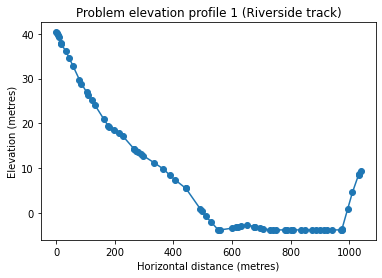

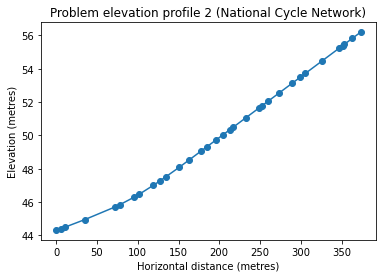

label: all2
smp: 23.591836734693874
slope: 2.66
cont: 2.66
ang: 1.28
R: 0.9855943837827182
loglik: -3595.041543073662
coeff: 1.039720841098199
int: 0.4385385152324428
ec/len err: 0.006886031460339792
min outlier: -36.25723589585006
max outlier: 38.44660432439078
riverside ec: 59.58235056024646
ncn ec: 11.853993993630816


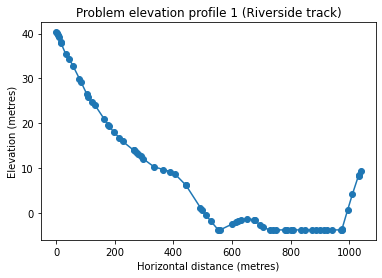

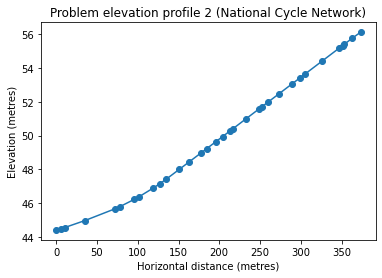

label: all2
smp: 27.93877551020408
slope: 2.66
cont: 2.66
ang: 1.28
R: 0.9865530352228752
loglik: -3547.1741112694017
coeff: 1.0347905586583768
int: 0.38332969920135795
ec/len err: 0.006637925927326375
min outlier: -35.96585858441665
max outlier: 37.341226162038765
riverside ec: 62.260659212278306
ncn ec: 11.728415530839186


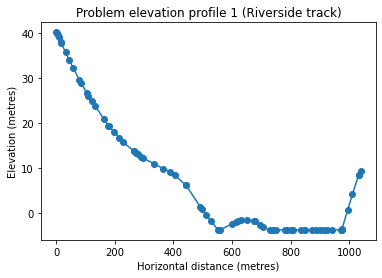

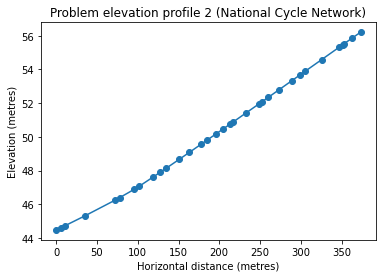

label: all2
smp: 32.6530612244898
slope: 2.66
cont: 2.66
ang: 1.28
R: 0.9865488051953861
loglik: -3547.3927859310697
coeff: 1.0353394353606082
int: 0.3826540378112586
ec/len err: 0.00664237409178576
min outlier: -35.91815361220952
max outlier: 37.045379640464084
riverside ec: 61.86801050912763
ncn ec: 11.730122099752414


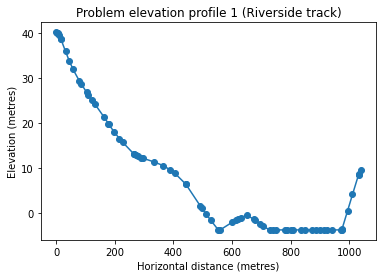

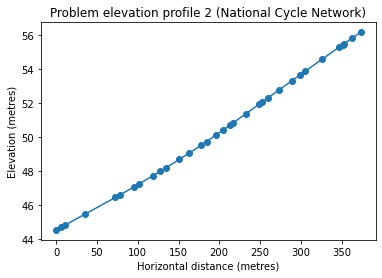

label: all2
smp: 37.73469387755102
slope: 2.66
cont: 2.66
ang: 1.28
R: 0.9870706011697848
loglik: -3519.8816606346995
coeff: 1.031936246724916
int: 0.3595476957429611
ec/len err: 0.006511703462872533
min outlier: -35.65414623254584
max outlier: 35.83828122995968
riverside ec: 63.69311438888012
ncn ec: 11.610814502245923


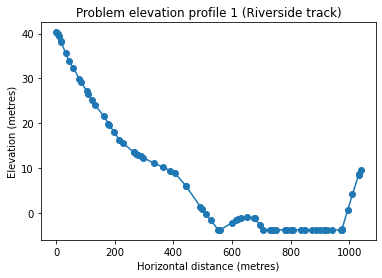

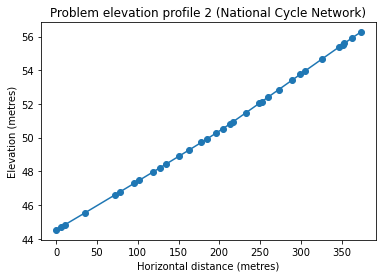

label: all2
smp: 43.18367346938775
slope: 2.66
cont: 2.66
ang: 1.28
R: 0.9869326765171185
loglik: -3527.2607893392824
coeff: 1.0327284789101356
int: 0.3653045001204749
ec/len err: 0.006540081794842848
min outlier: -36.25602621938033
max outlier: 36.316189724785815
riverside ec: 62.9584906265635
ncn ec: 11.733375771741002


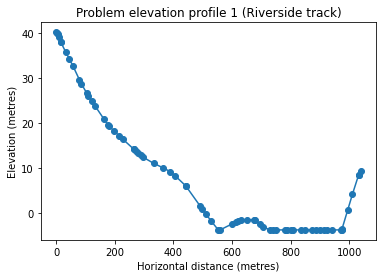

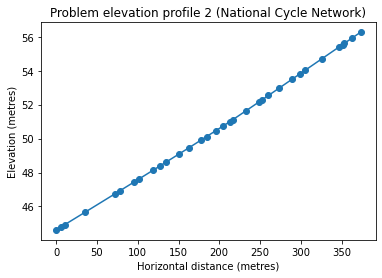

label: all2
smp: 49.0
slope: 2.66
cont: 2.66
ang: 1.28
R: 0.9863998719008673
loglik: -3555.0481979685537
coeff: 1.0357606198467846
int: 0.39579883806885974
ec/len err: 0.006690750673725455
min outlier: -36.05970747805476
max outlier: 36.806291315454914
riverside ec: 61.78981199187436
ncn ec: 11.646504061739549


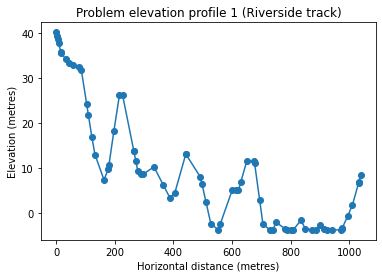

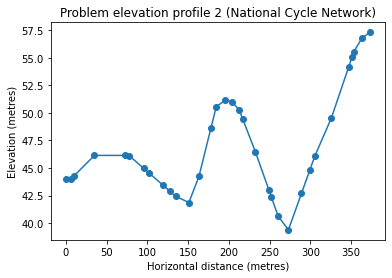

label: slp+weakpitch2
smp: 1.0
slope: 2.66
cont: inf
ang: 2.56
R: 0.9717894914368697
loglik: -4060.611264267067
coeff: 0.9293278335328584
int: 0.5412173291758418
ec/len err: 0.007851465146499455
min outlier: -87.12900095981934
max outlier: 15.807112593436685
riverside ec: 156.9820448356186
ncn ec: 45.39608152417655


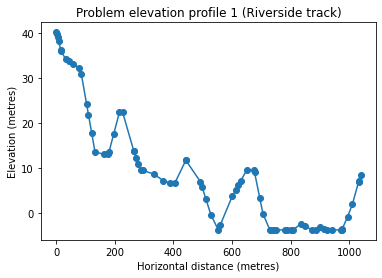

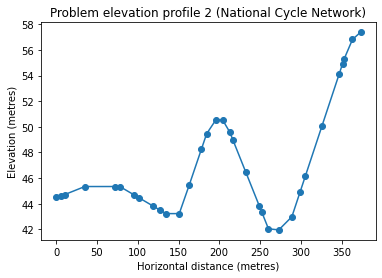

label: slp+weakpitch2
smp: 2.0408163265306123
slope: 2.66
cont: inf
ang: 2.56
R: 0.9836906917291487
loglik: -3681.2525960568737
coeff: 0.9780078495062813
int: 0.28386055683816913
ec/len err: 0.006545830373636678
min outlier: -54.07193634955687
max outlier: 16.33371929892178
riverside ec: 115.63105127408531
ncn ec: 34.23336181492247


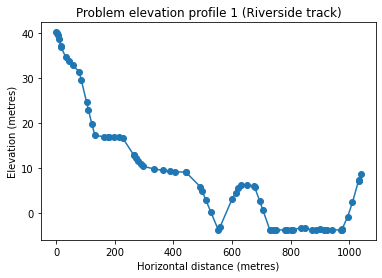

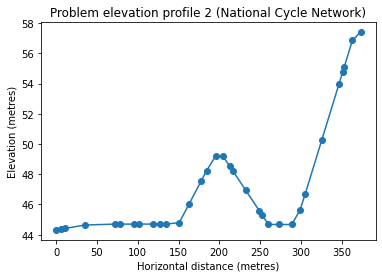

label: slp+weakpitch2
smp: 3.4489795918367347
slope: 2.66
cont: inf
ang: 2.56
R: 0.9879695571461858
loglik: -3469.7539218368147
coeff: 1.0126498993830961
int: 0.2615969152043771
ec/len err: 0.006177854664943044
min outlier: -34.863249548786555
max outlier: 25.74946332041651
riverside ec: 77.93833142517695
ncn ec: 22.180323334633748


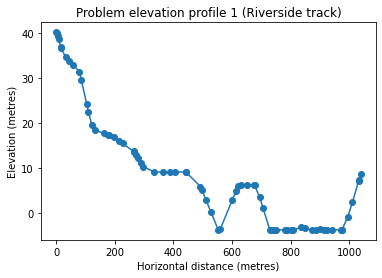

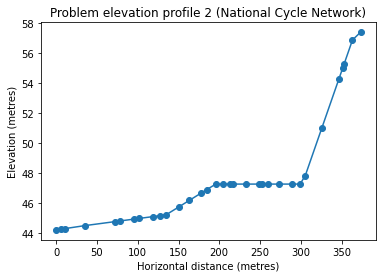

label: slp+weakpitch2
smp: 5.224489795918367
slope: 2.66
cont: inf
ang: 2.56
R: 0.9879150624158882
loglik: -3472.8983883421424
coeff: 1.0103454966034924
int: 0.25570799180868775
ec/len err: 0.006162341084983136
min outlier: -35.71061633068055
max outlier: 25.023463082470343
riverside ec: 78.29392005144425
ncn ec: 13.154509285117179


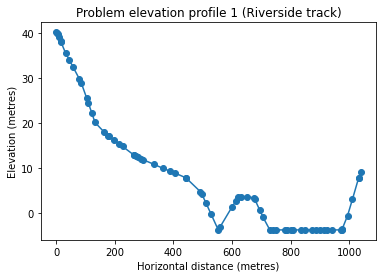

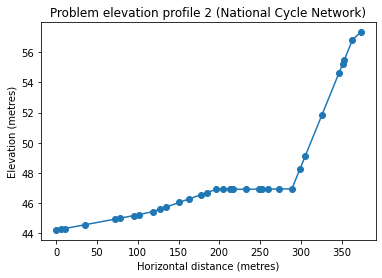

label: slp+weakpitch2
smp: 7.367346938775511
slope: 2.66
cont: inf
ang: 2.56
R: 0.9869127032853947
loglik: -3528.3228766095062
coeff: 1.0246786762326896
int: 0.3666045560099782
ec/len err: 0.00645788145530644
min outlier: -35.4682216057749
max outlier: 33.53160954707975
riverside ec: 71.76303177018546
ncn ec: 13.130636692482675


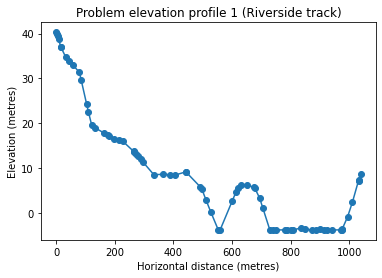

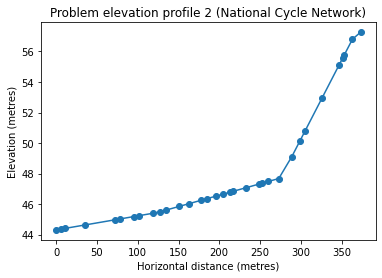

label: slp+weakpitch2
smp: 9.877551020408163
slope: 2.66
cont: inf
ang: 2.56
R: 0.9879460516514327
loglik: -3471.111994878491
coeff: 1.0120141313941104
int: 0.27926587596883934
ec/len err: 0.00618022352324103
min outlier: -35.753108513939424
max outlier: 25.737632669534435
riverside ec: 79.42352773500538
ncn ec: 12.950098170938908


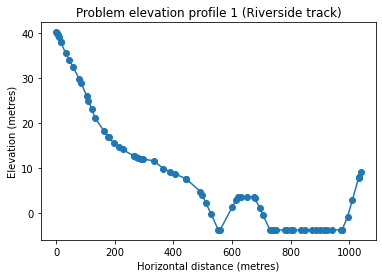

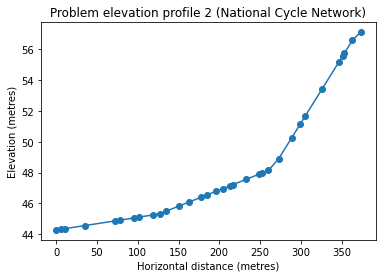

label: slp+weakpitch2
smp: 12.755102040816325
slope: 2.66
cont: inf
ang: 2.56
R: 0.987081917654852
loglik: -3519.2727023290417
coeff: 1.0241885986024317
int: 0.3634663055403671
ec/len err: 0.006446536029554881
min outlier: -35.348248645983645
max outlier: 32.859978758739516
riverside ec: 71.75913402952395
ncn ec: 12.848616633002415


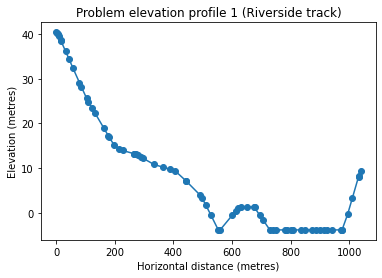

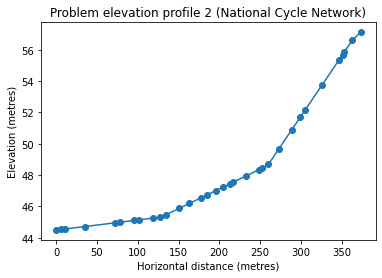

label: slp+weakpitch2
smp: 16.0
slope: 2.66
cont: inf
ang: 2.56
R: 0.9857761934931881
loglik: -3586.2148860308707
coeff: 1.0325100015675408
int: 0.4339956538409062
ec/len err: 0.006777210280687583
min outlier: -36.000437694073284
max outlier: 36.617440952818654
riverside ec: 67.68218428050699
ncn ec: 12.62290657438217


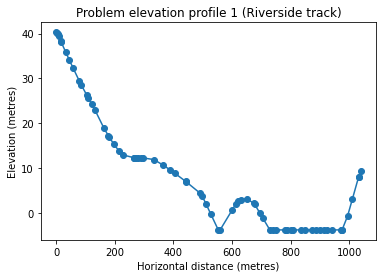

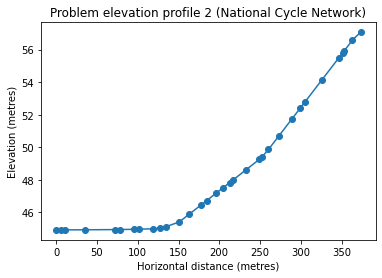

label: slp+weakpitch2
smp: 19.612244897959187
slope: 2.66
cont: inf
ang: 2.56
R: 0.9865426989157539
loglik: -3547.7083328645554
coeff: 1.0274882730521961
int: 0.39111358653947725
ec/len err: 0.006565666310660665
min outlier: -35.613462214470886
max outlier: 35.205849960518115
riverside ec: 71.065209533533
ncn ec: 12.142454162899632


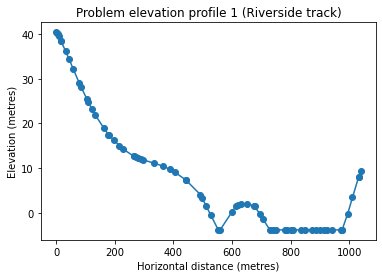

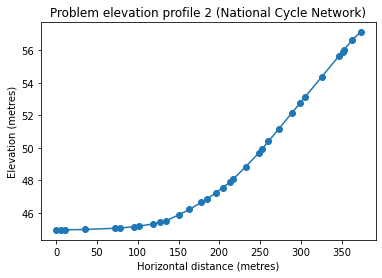

label: slp+weakpitch2
smp: 23.591836734693874
slope: 2.66
cont: inf
ang: 2.56
R: 0.9861170290687703
loglik: -3569.357153221011
coeff: 1.0304212735963014
int: 0.41477600093566913
ec/len err: 0.006676294914673098
min outlier: -35.8289280746596
max outlier: 36.14518449328739
riverside ec: 68.9012529776585
ncn ec: 12.150168925693933


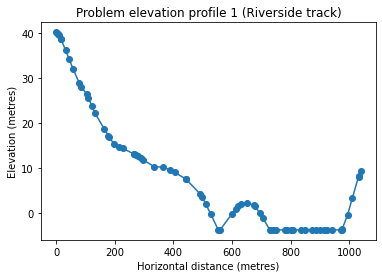

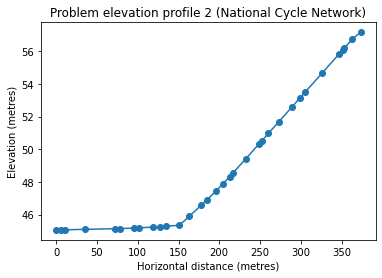

label: slp+weakpitch2
smp: 27.93877551020408
slope: 2.66
cont: inf
ang: 2.56
R: 0.9861806919335488
loglik: -3566.1622319424405
coeff: 1.030184444077717
int: 0.40791781963649143
ec/len err: 0.006656981074759894
min outlier: -35.98150208748396
max outlier: 36.151537841508784
riverside ec: 69.36592942814941
ncn ec: 12.10050621997889


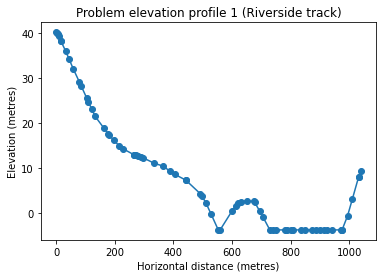

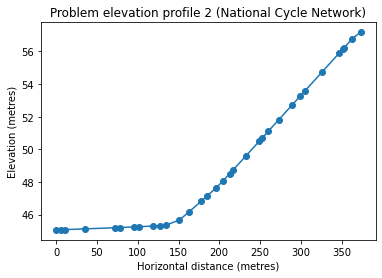

label: slp+weakpitch2
smp: 32.6530612244898
slope: 2.66
cont: inf
ang: 2.56
R: 0.9864421314364072
loglik: -3552.8846008958644
coeff: 1.0283375251641733
int: 0.39429370158994104
ec/len err: 0.006585068892254382
min outlier: -35.64731905778619
max outlier: 35.31146897575614
riverside ec: 70.06683688929584
ncn ec: 12.116897144597097


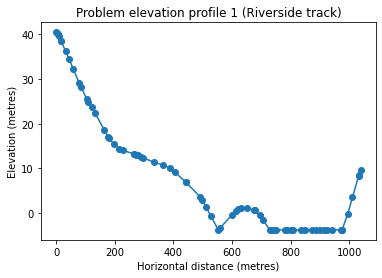

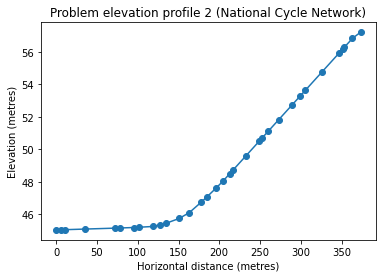

label: slp+weakpitch2
smp: 37.73469387755102
slope: 2.66
cont: inf
ang: 2.56
R: 0.9856006390719425
loglik: -3594.739724281694
coeff: 1.0335399411453041
int: 0.44456371825502217
ec/len err: 0.006826641875729622
min outlier: -36.02337605994849
max outlier: 36.68335566285795
riverside ec: 67.30706666062936
ncn ec: 12.17363785860028


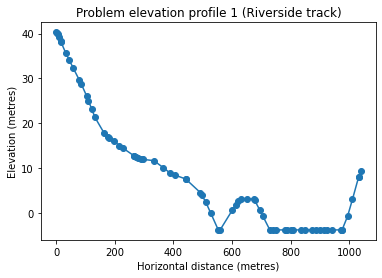

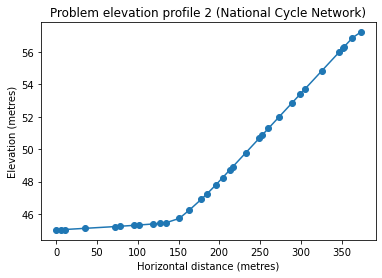

label: slp+weakpitch2
smp: 43.18367346938775
slope: 2.66
cont: inf
ang: 2.56
R: 0.9867744628442398
loglik: -3535.629457295032
coeff: 1.0261995327376594
int: 0.3788217216008114
ec/len err: 0.006513491818857293
min outlier: -35.48149284642501
max outlier: 34.29863416666659
riverside ec: 71.16820158649621
ncn ec: 12.1804477474655


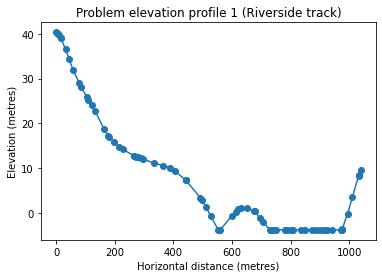

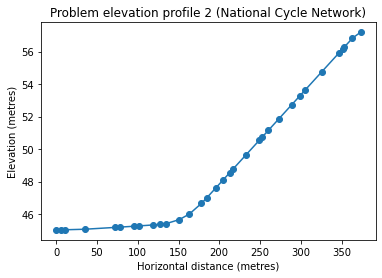

label: slp+weakpitch2
smp: 49.0
slope: 2.66
cont: inf
ang: 2.56
R: 0.9857616902402062
loglik: -3586.923162347918
coeff: 1.033441057675155
int: 0.43840738673225843
ec/len err: 0.006790879934913869
min outlier: -36.08161398190744
max outlier: 35.93487458948897
riverside ec: 67.09421936221622
ncn ec: 12.155040308347665


In [8]:
sensitivity(slope=2.66,pitch=1.28,label="slp+pitch2")
sensitivity(slope=2.66,cont=2.66,pitch=1.28*2,label="slp+cont+weakpitch2")
sensitivity(slope=2.66,label="slope2")
sensitivity(cont=2.66,label="cont2")
sensitivity(pitch=1.28,label="pitch2")
sensitivity(slope=2.66,cont=2.66,label="slp+cont2")
sensitivity(slope=2.66,cont=2.66,pitch=1.28,label="all2")
sensitivity(slope=2.66,pitch=1.28*2,label="slp+weakpitch2")





Max loglik for slope2: -3513.855 for smp=3.4489795918367347
Min loglik for slope2: -4812.272 for smp=49.0
Max loglik for cont2: -3430.706 for smp=3.4489795918367347
Min loglik for cont2: -4880.190 for smp=49.0
Max loglik for pitch2: -3528.664 for smp=43.18367346938775
Min loglik for pitch2: -3789.806 for smp=5.224489795918367
Max loglik for slp+cont2: -3567.408 for smp=3.4489795918367347
Min loglik for slp+cont2: -5130.159 for smp=49.0
Max loglik for slp+pitch2: -3461.453 for smp=3.4489795918367347
Min loglik for slp+pitch2: -3513.289 for smp=9.877551020408164
Max loglik for all2: -3452.008 for smp=3.4489795918367347
Min loglik for all2: -3595.042 for smp=23.591836734693874


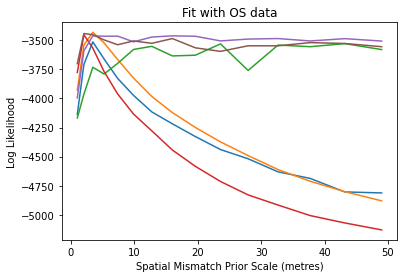

Max R for slope2: 0.987 for smp=3.4489795918367347
Min R for slope2: 0.915 for smp=49.0
Max R for cont2: 0.989 for smp=3.4489795918367347
Min R for cont2: 0.906 for smp=49.0
Max R for pitch2: 0.987 for smp=43.18367346938775
Min R for pitch2: 0.981 for smp=5.224489795918367
Max R for slp+cont2: 0.986 for smp=3.4489795918367347
Min R for slp+cont2: 0.862 for smp=49.0
Max R for slp+pitch2: 0.988 for smp=3.4489795918367347
Min R for slp+pitch2: 0.987 for smp=9.877551020408164
Max R for all2: 0.988 for smp=3.4489795918367347
Min R for all2: 0.986 for smp=23.591836734693874


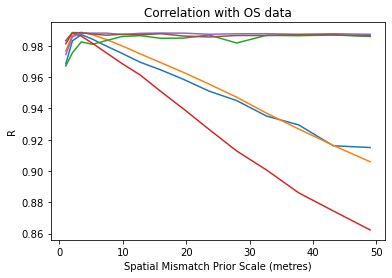

Max coeff for slope2: 1.072 for smp=27.93877551020408
Min coeff for slope2: 1.018 for smp=3.4489795918367347
Max coeff for cont2: 1.151 for smp=49.0
Min coeff for cont2: 1.017 for smp=3.4489795918367347
Max coeff for pitch2: 0.991 for smp=43.18367346938775
Min coeff for pitch2: 0.962 for smp=5.224489795918367
Max coeff for slp+cont2: 1.099 for smp=23.591836734693874
Min coeff for slp+cont2: 1.038 for smp=3.4489795918367347
Max coeff for slp+pitch2: 1.023 for smp=9.877551020408164
Min coeff for slp+pitch2: 1.010 for smp=3.4489795918367347
Max coeff for all2: 1.040 for smp=23.591836734693874
Min coeff for all2: 1.020 for smp=3.4489795918367347


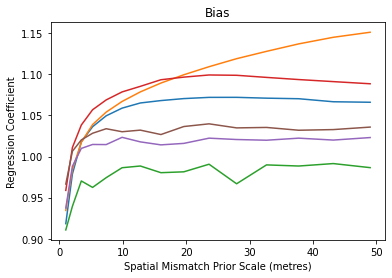

Max int for slope2: 3.375 for smp=49.0
Min int for slope2: 0.347 for smp=3.4489795918367347
Max int for cont2: 2.872 for smp=49.0
Min int for cont2: 0.198 for smp=3.4489795918367347
Max int for pitch2: 0.361 for smp=5.224489795918367
Min int for pitch2: 0.269 for smp=23.591836734693874
Max int for slp+cont2: 4.352 for smp=49.0
Min int for slp+cont2: 0.416 for smp=3.4489795918367347
Max int for slp+pitch2: 0.344 for smp=9.877551020408164
Min int for slp+pitch2: 0.248 for smp=3.4489795918367347
Max int for all2: 0.439 for smp=23.591836734693874
Min int for all2: 0.273 for smp=3.4489795918367347


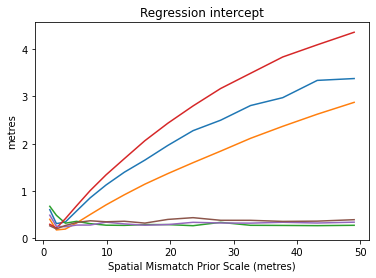

Max ec/len err for slope2: 0.019 for smp=49.0
Min ec/len err for slope2: 0.006 for smp=3.4489795918367347
Max ec/len err for cont2: 0.020 for smp=49.0
Min ec/len err for cont2: 0.006 for smp=3.4489795918367347
Max ec/len err for pitch2: 0.007 for smp=5.224489795918367
Min ec/len err for pitch2: 0.006 for smp=43.18367346938775
Max ec/len err for slp+cont2: 0.024 for smp=49.0
Min ec/len err for slp+cont2: 0.007 for smp=3.4489795918367347
Max ec/len err for slp+pitch2: 0.006 for smp=9.877551020408164
Min ec/len err for slp+pitch2: 0.006 for smp=3.4489795918367347
Max ec/len err for all2: 0.007 for smp=23.591836734693874
Min ec/len err for all2: 0.006 for smp=3.4489795918367347


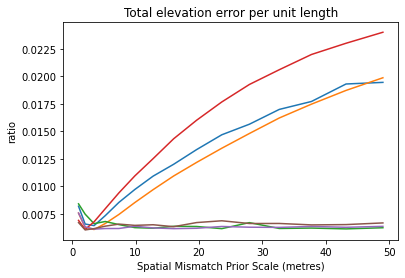

Max min outlier for slope2: -30.338 for smp=32.6530612244898
Min min outlier for slope2: -35.900 for smp=7.367346938775511
Max min outlier for cont2: -33.076 for smp=49.0
Min min outlier for cont2: -35.880 for smp=3.4489795918367347
Max min outlier for pitch2: -40.575 for smp=12.755102040816324
Min min outlier for pitch2: -64.255 for smp=5.224489795918367
Max min outlier for slp+cont2: -32.294 for smp=49.0
Min min outlier for slp+cont2: -36.710 for smp=7.367346938775511
Max min outlier for slp+pitch2: -34.785 for smp=19.612244897959187
Min min outlier for slp+pitch2: -35.896 for smp=3.4489795918367347
Max min outlier for all2: -34.979 for smp=3.4489795918367347
Min min outlier for all2: -36.257 for smp=23.591836734693874


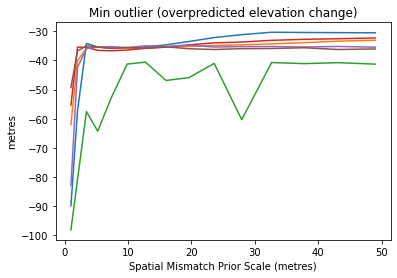

Max max outlier for slope2: 121.352 for smp=49.0
Min max outlier for slope2: 28.246 for smp=3.4489795918367347
Max max outlier for cont2: 133.504 for smp=49.0
Min max outlier for cont2: 27.822 for smp=3.4489795918367347
Max max outlier for pitch2: 16.990 for smp=43.18367346938775
Min max outlier for pitch2: 15.676 for smp=5.224489795918367
Max max outlier for slp+cont2: 164.105 for smp=49.0
Min max outlier for slp+cont2: 36.601 for smp=3.4489795918367347
Max max outlier for slp+pitch2: 33.157 for smp=9.877551020408164
Min max outlier for slp+pitch2: 24.417 for smp=3.4489795918367347
Max max outlier for all2: 38.447 for smp=23.591836734693874
Min max outlier for all2: 30.617 for smp=3.4489795918367347


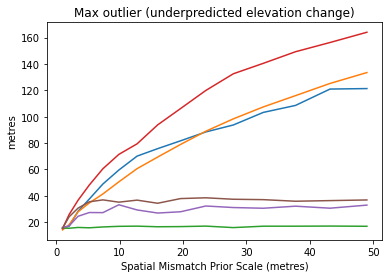

Max riverside ec for slope2: 80.102 for smp=3.4489795918367347
Min riverside ec for slope2: 58.666 for smp=49.0
Max riverside ec for cont2: 74.246 for smp=3.4489795918367347
Min riverside ec for cont2: 39.515 for smp=49.0
Max riverside ec for pitch2: 128.001 for smp=5.224489795918367
Min riverside ec for pitch2: 90.953 for smp=43.18367346938775
Max riverside ec for slp+cont2: 67.387 for smp=3.4489795918367347
Min riverside ec for slp+cont2: 43.565 for smp=49.0
Max riverside ec for slp+pitch2: 77.989 for smp=3.4489795918367347
Min riverside ec for slp+pitch2: 71.604 for smp=49.0
Max riverside ec for all2: 70.765 for smp=3.4489795918367347
Min riverside ec for all2: 59.582 for smp=23.591836734693874


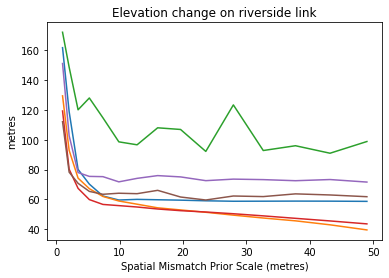

Max ncn ec for slope2: 23.788 for smp=3.4489795918367347
Min ncn ec for slope2: 9.966 for smp=43.18367346938775
Max ncn ec for cont2: 20.867 for smp=3.4489795918367347
Min ncn ec for cont2: 10.919 for smp=49.0
Max ncn ec for pitch2: 33.353 for smp=3.4489795918367347
Min ncn ec for pitch2: 13.135 for smp=23.591836734693874
Max ncn ec for slp+cont2: 14.660 for smp=3.4489795918367347
Min ncn ec for slp+cont2: 10.818 for smp=49.0
Max ncn ec for slp+pitch2: 18.704 for smp=3.4489795918367347
Min ncn ec for slp+pitch2: 12.096 for smp=32.6530612244898
Max ncn ec for all2: 13.048 for smp=3.4489795918367347
Min ncn ec for all2: 11.611 for smp=37.73469387755102


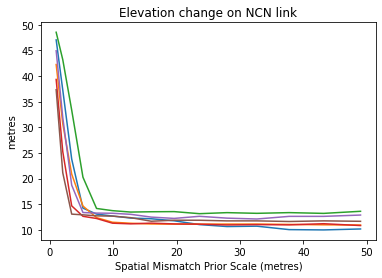

Max ncn ec for slope2: 23.788 for smp=3.4489795918367347
Min ncn ec for slope2: 9.966 for smp=43.18367346938775
Max ncn ec for cont2: 20.867 for smp=3.4489795918367347
Min ncn ec for cont2: 10.919 for smp=49.0
Max ncn ec for pitch2: 33.353 for smp=3.4489795918367347
Min ncn ec for pitch2: 13.135 for smp=23.591836734693874
Max ncn ec for slp+cont2: 14.660 for smp=3.4489795918367347
Min ncn ec for slp+cont2: 10.818 for smp=49.0
Max ncn ec for slp+pitch2: 18.704 for smp=3.4489795918367347
Min ncn ec for slp+pitch2: 12.096 for smp=32.6530612244898
Max ncn ec for all2: 13.048 for smp=3.4489795918367347
Min ncn ec for all2: 11.611 for smp=37.73469387755102


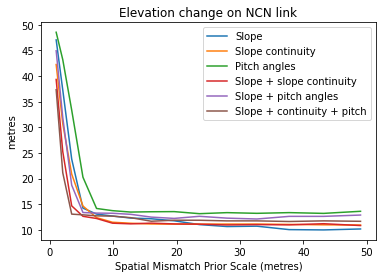

In [21]:
models = [("slope2","Slope"),
         ("cont2","Slope continuity"),
         ("pitch2","Pitch angles"),
         ("slp+cont2","Slope + slope continuity"),
         ("slp+pitch2","Slope + pitch angles"),
         #("slp+cont+weakpitch2","Slope + continuity + weak pitch"),
         ("all2","Slope + continuity + pitch")]
         #("slp+weakpitch2","Slope + weak pitch") ]

def senstest(column,ylabel,title,legend=False):
    plt.figure()
    df = pd.read_csv("sensitivity2.csv")
    for key,label in models:
        model = df[df.label==key]
        plt.plot(model.smp,model[column],label=label)
        model = model[model.smp>3]
        maxrow = model[model[column]==model[column].max()]
        minrow = model[model[column]==model[column].min()]
        print(f"Max {column} for {key}: {float(maxrow[column]):.3f} for smp={float(maxrow.smp)}")
        print(f"Min {column} for {key}: {float(minrow[column]):.3f} for smp={float(minrow.smp)}")
    plt.xlabel("Spatial Mismatch Prior Scale (metres)")
    plt.ylabel(ylabel)
    if legend:
        plt.legend()
    plt.title(title)
    plt.show()

    
senstest("loglik","Log Likelihood","Fit with OS data")
senstest("R","R","Correlation with OS data")
senstest("coeff","Regression Coefficient","Bias")
senstest("int","metres","Regression intercept")
senstest("ec/len err","ratio","Total elevation error per unit length")
senstest("min outlier","metres","Min outlier (overpredicted elevation change)")
senstest("max outlier","metres","Max outlier (underpredicted elevation change)")
senstest("riverside ec","metres","Elevation change on riverside link")
senstest("ncn ec","metres","Elevation change on NCN link")
senstest("ncn ec","metres","Elevation change on NCN link",True)


Problem elevation profile 1 (Riverside track)
ec for Slope (5m) = 71.2517859338663
ec for Slope (7m) †† = 63.48874830120735
ec for Slope (50m) †† = 58.68193089656436


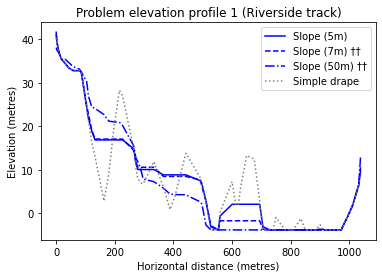

Problem elevation profile 2 (National Cycle Network)
ec for Slope (5m) = 14.833184391572956
ec for Slope (7m) †† = 13.05662605054522
ec for Slope (50m) †† = 10.236432167901192


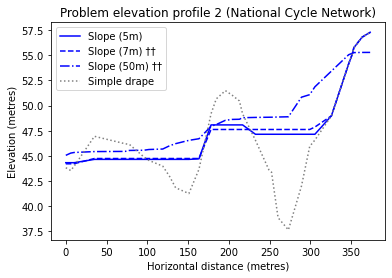

Problem elevation profile 1 (Riverside track)
ec for Slope continuity (5m) = 67.59059681762247
ec for Slope continuity (16m) †† = 54.33531123797199


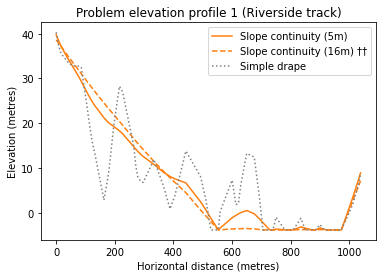

Problem elevation profile 2 (National Cycle Network)
ec for Slope continuity (5m) = 15.142869616927982
ec for Slope continuity (16m) †† = 11.122814663442554


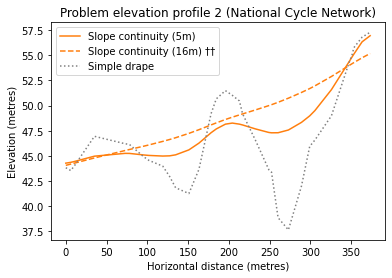

Problem elevation profile 1 (Riverside track)
ec for Pitch angles (20m) = 92.01586295753603
ec for Slope + pitch angles (7m) = 75.45694910518128


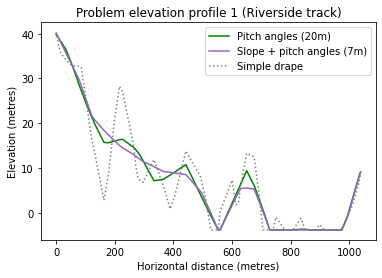

Problem elevation profile 2 (National Cycle Network)
ec for Pitch angles (20m) = 13.259897448133344
ec for Slope + pitch angles (7m) = 13.339333171657472


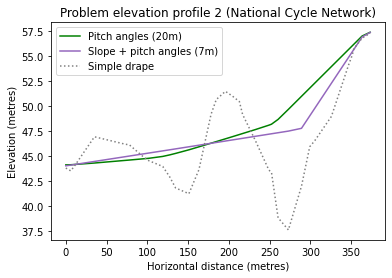

Problem elevation profile 1 (Riverside track)
ec for Slope + continuity + pitch (24m) = 60.24498645434965


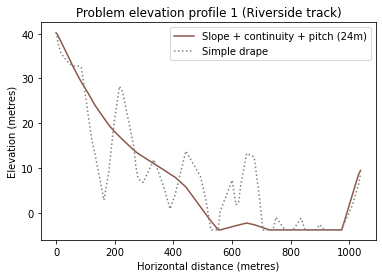

Problem elevation profile 2 (National Cycle Network)
ec for Slope + continuity + pitch (24m) = 11.803445420011492


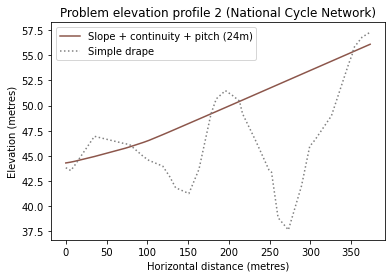

In [24]:
def plot_single(geom,label,fmt="",linecolor=""):
    zs = [geom.coords[0][2]]
    xs = [0]
    for (x1,y1,z1),(x2,y2,z2) in  pairwise(list(geom.coords)):
        xs += [xs[-1] + ((y2-y1)**2+(x2-x1)**2)**0.5]
        zs += [z2]
    #plt.scatter(xs,zs,label=label)
    if linecolor:
        plt.plot(xs,zs,fmt,label=label,color=linecolor)
    else:
        plt.plot(xs,zs,fmt,label=label)
    
def plot_profiles(which,smps,sps=90,scps=np.inf,paps=np.inf,label="",fmt="",linecolor=""):
    if which=="bigsweir":
        input_net = "finaltest"
        fid=1172
        idfield="ID"
    elif which=="bulwark":
        input_net = "bulwark"
        fid=1099
        idfield="fid"
    else:
        assert False
    
    draped_net_filename = test_drape(input_net,smps,sps,scps,paps,refresh=False)
    draped_net = gp.read_file(draped_net_filename)
    link = draped_net[draped_net[idfield]==fid].geometry.iloc[0]
    plot_single(link,label=label,fmt=fmt,linecolor=linecolor)
    return elev_change(link)
    

    
def plot_model_list(models,which,title):
    plt.figure()
    print(title)
    for key,modelname,smp,sps,cont,ang,fmt in models:
        ec=plot_profiles(which,smp,sps,cont,ang,label=modelname,fmt=fmt,linecolor=None)
        print(f"ec for {modelname} = {ec}")
    plot_profiles(which,0,90,np.inf,np.inf,label="Simple drape",fmt=":",linecolor="grey")
    plt.xlabel("Horizontal distance (metres)")
    plt.ylabel("Elevation (metres)")
    plt.title(title)
    plt.legend()
    plt.show()
    
# lowest smp good slope profiles for which overall model fit is good
models = [("slope","Slope (5m)",5,2.66,np.inf,np.inf,"-b"),
          ("slope","Slope (7m) ††",7,2.66,np.inf,np.inf,"--b"),
         ("slope","Slope (50m) ††",50,2.66,np.inf,np.inf,"-.b")]

plot_model_list(models,"bigsweir","Problem elevation profile 1 (Riverside track)")
plot_model_list(models,"bulwark","Problem elevation profile 2 (National Cycle Network)")

models = [("cont","Slope continuity (5m)",5,90,2.66,np.inf,"-C1"),
          ("cont","Slope continuity (16m) ††",16,90,2.66,np.inf,"--C1")]

#plot_model_list(models,"bigsweir","Problem elevation profile 1 (Riverside track)")
#plot_model_list(models,"bulwark","Problem elevation profile 2 (National Cycle Network)")

#models = [("slp+cont","Slope + slope continuity",16,2.66,0.058,np.inf),
#         ("slp+cont","Slope + slope continuity",5,2.66,0.058,np.inf)]

plot_model_list(models,"bigsweir","Problem elevation profile 1 (Riverside track)")
plot_model_list(models,"bulwark","Problem elevation profile 2 (National Cycle Network)")

models = [("pitch","Pitch angles (20m)",20,90,np.inf,1.28,"-g"),
         ("slp+pitch","Slope + pitch angles (7m)",7,2.66,np.inf,1.28,"-C4")]

# other profiles
         
#         ("slp+cont+weakpitch","Slope + continuity + weak pitch",37,2.66,0.058,2.6) ]

plot_model_list(models,"bigsweir","Problem elevation profile 1 (Riverside track)")
plot_model_list(models,"bulwark","Problem elevation profile 2 (National Cycle Network)")

models = [
          ("slp+cont+pitch","Slope + continuity + pitch (24m)",24,2.66,2.66,1.28,"-C5") ]


plot_model_list(models,"bigsweir","Problem elevation profile 1 (Riverside track)")
plot_model_list(models,"bulwark","Problem elevation profile 2 (National Cycle Network)")
